# 1. Data Background and Problem Formulation

In this project, a dataset is given with 900+ data each corresponding to individual indicators of users' experience surveys revolving around proposed system designs -- and how would potential users react or perceive this notion. 

The goal is to provide a deep learning model with an acceptable rate of AUC (0.7 to 0.9) on test dataset in order to be able to predict certain words clearly.

To gain a better sense of the data, we first import the necessities to run the overall code.

---


In [1]:
# Configure output settings to prettify print display

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
# Ignore warnings to prettify print

import warnings
warnings.filterwarnings("ignore")

In [10]:
!pip install scikit-multilearn
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import imblearn

You should consider upgrading via the 'c:\users\chari\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


##1.1. Importing the data
We can then import the data via `pandas` package to see the overall nature of the data, the outputs, and the datatypes.

In [12]:
df = pd.read_excel('Sample.xlsx', sheet_name='PROMISE-Extended_Ivan33')
df.drop(columns=['ID', 'ProjectID', 'Class'], axis=1, inplace=True)
df.sample(n=10, random_state=1)

Requirements  \
718  Secure data transfer over the Internet could b...   
637  The system shall validate the amount is availa...   
759  Sensitive data will be encrypted before being ...   
366  PME Subsystem shall allow building product men...   
543  The system shall be responsive. At the DePaul ...   
41   The product shall synchronize with the office ...   
120  Program Administrators and Nursing Staff Membe...   
725  It must be able to download the most recent me...   
795  Customer must logout of the site after purchas...   
672  Changes made to the Manage My ID website can b...   

     obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
718                          7                    5                         6   
637                          7                    6                         7   
759                          7                    6                         7   
366                          5                    4                         6   
543                          6                    6                         7   
41                           5                    5                         5   
120                          6                    5                         6   
725                          6                    7                         6   
795                          3                    2                         3   
672                          4                    3                         4   

      confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
718                    6                   3                               4   
637                    7                   2                               3   
759                    7                   4                               4   
366                    5                   3                               4   
543                    7                   5                               6   
41                     5                   5                               4   
120                    5                   5                               4   
725                    7                   3                               4   
795                    2                   1                               2   
672                    3                   3                               4   

     conventional<==>inventive  usual<==>leading edge  
718                          3                      3  
637                          1                      1  
759                          2                      3  
366                          4                      4  
543                          3                      4  
41                           4                      5  
120                          3                      2  
725                          3                      3  
795                          4                      6  
672                          4                      5

In [23]:
data=df.copy()
df.columns

Index(['Requirements', 'obstructive<==>supportive', 'complicated<==>easy',
       'inefficient<==>efficient', ' confusing<==>clear', 'boring<==>exciting',
       'not interesting<==>interesting', 'conventional<==>inventive',
       'usual<==>leading edge'],
      dtype='object')

In [24]:
data['mix']=data['obstructive<==>supportive']+data['complicated<==>easy']+data['inefficient<==>efficient']+data[' confusing<==>clear']+data['boring<==>exciting']+data['not interesting<==>interesting']+data['conventional<==>inventive']+data['usual<==>leading edge']

In [26]:
data.head()

Requirements  \
0  The system shall refresh the display every 60 ...   
1  The application shall match the color of the s...   
2  If projected  the data must be readable.  On a...   
3  The product shall be available during normal b...   
4  If projected  the data must be understandable....   

   obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
0                          3                    4                         3   
1                          7                    2                         5   
2                          7                    4                         7   
3                          7                    2                         7   
4                          7                    2                         7   

    confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
0                    3                   4                               3   
1                    5                   3                               3   
2                    7                   5                               5   
3                    5                   5                               5   
4                    7                   5                               7   

   conventional<==>inventive  usual<==>leading edge  mix  
0                          6                      6   32  
1                          6                      6   37  
2                          5                      4   44  
3                          5                      6   42  
4                          3                      3   41

## 1.2. Column Definitions
### 1.2.1. Features

Features are only represented in the first column, which is the `Requirements` column. This column represents the question and/or the funcionalities of the system itself.

### 1.2.2. Labels

Labels, on the other hand, comprised of 8 columns in total. They are:
* **obstructive<==>supportive**, measuring supportiveness.
* **complicated<==>easy**, measuring ease-of-use.
* **inefficient<==>efficient**, measuring efficiency.
* **confusing<==>clear**, measuring brevity and clarity.
* **boring<==>exciting**, measuring excitement.
* **not interesting<==>interesting**, measuring appeal.
* **conventional<==>inventive**, measuring innovation.
* **usual<==>leading edge**, measuring technology usage.

The scales on the labels vary from 1 to 7, in which values closer to 1 corresponds to a more negative connotation, while values closer to 7 is likely to be more positive.

For example, for column `boring<==>exciting`, if a user gives it a 3, whilst this may seem neutral at first glance, we can infer that the user does not regard this system design as easy-to-use -- otherwise they would give it a score of 5 or 6.

For this task, we'll run multiclass multilabel regression since we obtained a good AUC with multiclass regression on one column before with simple regression. **The trick here is to not use a single column.**

With this, we might want to approach the problem within the scope of [Multi-output Regression](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/)

First, we separate the labels from the data.

In [27]:
features = df.iloc[:, 0].values # First column in the entire set
labels = df.iloc[:, np.r_[1:9]].values
print("Features is now of type:", type(features), "with shape", features.shape)
print("Labels is now of type:", type(labels), "with shape", labels.shape)

Features is now of type: <class 'numpy.ndarray'> with shape (969,)
Labels is now of type: <class 'numpy.ndarray'> with shape (969, 8)


We know from previous work that the dataset is very much imbalanced, so we would want to try oversampling across all columns and make them our new label. But first, we would want to convert features as word vectors first.

## 1.3. Quick EDA

We can visualize the most used words via `wordcloud` used in our dataset.

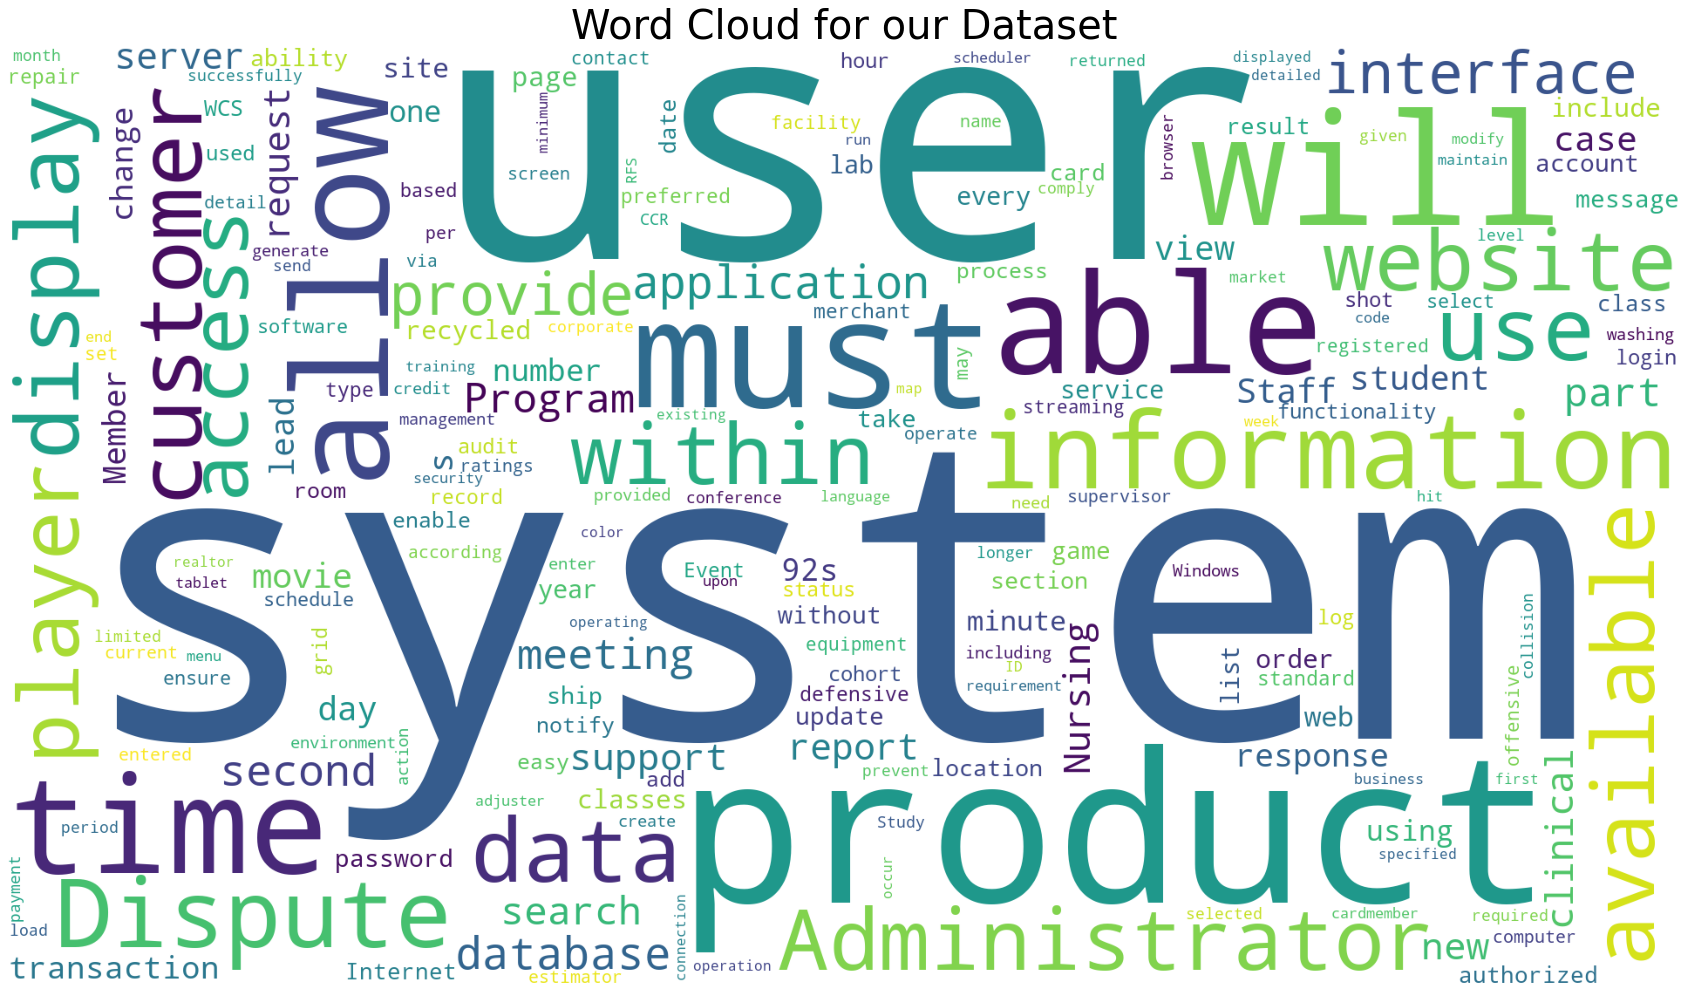

In [28]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(30,20))
text =df['Requirements'].values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1920,
                          height=1080
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Word Cloud for our Dataset",fontsize=40)
plt.imshow(cloud)

In [29]:
from collections import Counter
for i in range(8):
  print("Column:", df.columns[1:][i])
  print(Counter(labels[:,i]))

Column: obstructive<==>supportive
Counter({7: 418, 6: 281, 5: 152, 4: 63, 3: 37, 2: 16, 1: 2})
Column: complicated<==>easy
Counter({6: 278, 5: 254, 7: 210, 4: 144, 3: 57, 2: 24, 1: 2})
Column: inefficient<==>efficient
Counter({7: 406, 6: 306, 5: 128, 4: 71, 3: 36, 2: 18, 1: 4})
Column:  confusing<==>clear
Counter({7: 443, 6: 245, 5: 148, 4: 68, 3: 38, 2: 23, 1: 4})
Column: boring<==>exciting
Counter({3: 256, 4: 249, 5: 185, 2: 142, 6: 89, 7: 26, 1: 22})
Column: not interesting<==>interesting
Counter({4: 265, 3: 245, 5: 222, 2: 103, 6: 92, 7: 23, 1: 19})
Column: conventional<==>inventive
Counter({3: 273, 2: 267, 4: 164, 5: 102, 1: 101, 6: 55, 7: 7})
Column: usual<==>leading edge
Counter({3: 259, 2: 253, 4: 177, 5: 112, 1: 101, 6: 61, 7: 6})


# 2. Pre-processing
---

## 2.1. Tokenization

Tokenization means splitting each word and vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary). This process cleans up our text, lowercase, and remove punctuations. This step is basically the same from our previous work involving LSTMs.

This way, we can see which words appear the most in our training set.

In [30]:
tokenizer = Tokenizer(num_words = 2000, oov_token="<OOV>")
tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'the': 2,
 'shall': 3,
 'to': 4,
 'system': 5,
 'of': 6,
 'be': 7,
 'a': 8,
 'and': 9,
 'product': 10}

After tokenization, the next step is to turn those tokens into lists of sequence.

In [31]:
sequences = tokenizer.texts_to_sequences(features)
print(sequences[0]) # This corresponds to the first sentence in the training data.

[2, 5, 3, 674, 2, 32, 96, 675, 49]


## 2.2. Padding

When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Padding means that we convert all instances of the training data towards the same size. To do this, we need to specify a fixed length to transform all the instances on.

For the project, we can set the sequence by looking quickly at the average proportion of the training words.

In [32]:
import math
word_counts = []
for i in (features):
  word_counts.append(len(i.split(" ")))
print("Average word counts:" , sum(word_counts)/len(word_counts))

# Round max length of padding to the nearest tenth
max_length = math.ceil((sum(word_counts)/len(word_counts))/10) * 10
print("Padded onto length: ", max_length)

# Delete unused variable
del word_counts 

Average word counts: 18.223942208462333
Padded onto length:  20


We can then proceed to do the actual padding. This is done for all instances of the training example.

In [33]:
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

for i in range(5):
  print("Sequence of length", len(sequences[i]), "was padded onto", len(padded[i]))

Sequence of length 9 was padded onto 20
Sequence of length 16 was padded onto 20
Sequence of length 29 was padded onto 20
Sequence of length 36 was padded onto 20
Sequence of length 35 was padded onto 20


In [34]:
padded

array([[  2,   5,   3, ...,   0,   0,   0],
       [  2,  45,   3, ...,   0,   0,   0],
       [ 69, 879,   2, ...,  17,   4, 451],
       ...,
       [  2,   1,  36, ...,  91, 309,  12],
       [  2,   5,   3, ...,   9, 102,   4],
       [  2,  36,  15, ..., 304,  15,   7]])

## 2.3. SMOTE Oversampling

Generally, oversampling makes fake data so that the minority labels are not squashed by the majority.

Constraint of using SMOTE within this dataset is that it's very fragile to classes with only one example. Since SMOTE works via k-nearest neighbors, at least two members of a class would be mandatory for it to work.

Synthetic samples generated with respect to the most amount of classes in all columns so that input shape (features and labels) are consistent against each other.

## REVISION: ROS Oversampling

ROS generates random data as opposed to the better, more superior SMOTE which generates "more credible" data. We can't use SMOTE on all sheets because of the `n_neighbors` and distance constraint.

We find the least common multiple of all class members amount, and oversample from there to get the matrix dimensions uniform.

In [35]:
import copy
from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
max_amount = np.lcm.reduce([1,2,3,4,5,6,7]) * 40
labels_processed = np.zeros((max_amount, 8))

for i in range(8):
  unique_classes = np.unique(df[df.columns[1:][i]])
  amount = [int(
      (max_amount/len(unique_classes)))
      ] * len(unique_classes)
  x = {k:v for (k,v) in zip(unique_classes, amount)}
  smt = RandomOverSampler(sampling_strategy=x)
  X, y = smt.fit_resample(padded, labels[:,i])
  labels_processed[:,i] = y
  print("Column", i, "done.")
  # We don't save nor use the X variable between each iteration, 
  # instead only using the last one.


print("Shape of input features is:", X.shape)
print("Shape of labels is:",labels_processed.shape)

Column 0 done.
Column 1 done.
Column 2 done.
Column 3 done.
Column 4 done.
Column 5 done.
Column 6 done.
Column 7 done.
Shape of input features is: (16800, 20)
Shape of labels is: (16800, 8)


In [36]:
# Sanity check time!
for i in range(8):
  print("For column", df.columns[1:][i])
  print(Counter(labels_processed[:,i]),"\n------")


print("First ten entries of the processed labels:\n", labels_processed[:10,:])
print("First ten entries of the processed features:\n", X[:10,:])

# Last and final assertion to catch matrix errors
try:
  assert(X.shape[0] == labels_processed.shape[0])
  print("Assertion completed!")
except AssertionError:
  print("Error!\nShape of X is", X.shape, "while labels is", labels_processed.shape)
  raise AssertionError

For column obstructive<==>supportive
Counter({3.0: 2400, 7.0: 2400, 5.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column complicated<==>easy
Counter({4.0: 2400, 2.0: 2400, 3.0: 2400, 6.0: 2400, 1.0: 2400, 5.0: 2400, 7.0: 2400}) 
------
For column inefficient<==>efficient
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column  confusing<==>clear
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 1.0: 2400, 4.0: 2400, 2.0: 2400}) 
------
For column boring<==>exciting
Counter({4.0: 2400, 3.0: 2400, 5.0: 2400, 2.0: 2400, 6.0: 2400, 7.0: 2400, 1.0: 2400}) 
------
For column not interesting<==>interesting
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 4.0: 2400, 6.0: 2400, 2.0: 2400, 1.0: 2400}) 
------
For column conventional<==>inventive
Counter({6.0: 2400, 5.0: 2400, 3.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400, 7.0: 2400}) 
------
For column usual<==>leading edge
Counter({6.0: 2400, 4.0: 2400, 3.0: 2400, 2.0: 2400, 5.0: 

## 2.4. Train-test Splitting

Finally we get to this part. We can use sklearn's `train_test_split` to do the usual splitting for test set (validation set is specified within building the model in the next section).

Also, specifying `random_state` ensures reproducibility.

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_processed, test_size=0.2, random_state=42)

# Sanity check again and again
print("Training examples:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test examples:", X_test.shape)
print("Test labels:", y_test.shape)

Training examples: (13440, 20)
Training labels: (13440, 8)
Test examples: (3360, 20)
Test labels: (3360, 8)


# 3. Modelling

## 3.1. Building the Model

Since we're training on augmented data, we're going to approach this as conventional regression compared to the LSTM approach we're doing it before.

LSTM model in this manner would result in a pretty bad metric score (around 0.5 to 0.7 F1-score) whereas our fully-connected dense layers resulted in a pretty satisfying F1, which is around 0.8 to 1 for each column.

In [40]:
# Wrapper functions for result interpretation
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def transform_results(estimates):
  res = []
  for x in estimates:
    if x > 7:
      x = 7
      res.append(x)
    else:
      res.append(x)
  return res

In [41]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)             

Epoch 1/150
588/588 - 1s - loss: 4.3697 - mae: 1.6274 - val_loss: 2.7521 - val_mae: 1.3696
Epoch 2/150
588/588 - 1s - loss: 2.1021 - mae: 1.1544 - val_loss: 1.3445 - val_mae: 0.9030
Epoch 3/150
588/588 - 1s - loss: 1.5183 - mae: 0.9559 - val_loss: 1.1783 - val_mae: 0.8192
Epoch 4/150
588/588 - 1s - loss: 1.3349 - mae: 0.8668 - val_loss: 1.0570 - val_mae: 0.7656
Epoch 5/150
588/588 - 1s - loss: 1.1838 - mae: 0.8042 - val_loss: 0.9611 - val_mae: 0.7286
Epoch 6/150
588/588 - 1s - loss: 1.1059 - mae: 0.7651 - val_loss: 0.9367 - val_mae: 0.6994
Epoch 7/150
588/588 - 1s - loss: 1.0167 - mae: 0.7123 - val_loss: 0.7505 - val_mae: 0.5935
Epoch 8/150
588/588 - 1s - loss: 0.9786 - mae: 0.6971 - val_loss: 0.7808 - val_mae: 0.5913
Epoch 9/150
588/588 - 1s - loss: 0.8923 - mae: 0.6573 - val_loss: 0.7627 - val_mae: 0.6006
Epoch 10/150
588/588 - 1s - loss: 0.8642 - mae: 0.6392 - val_loss: 0.7448 - val_mae: 0.5575
Epoch 11/150
588/588 - 1s - loss: 0.8353 - mae: 0.6201 - val_loss: 0.7102 - val_mae: 0.54

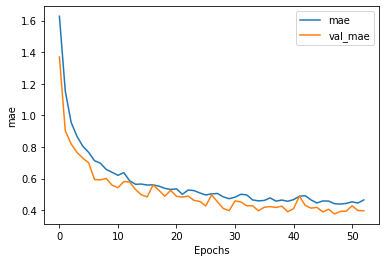

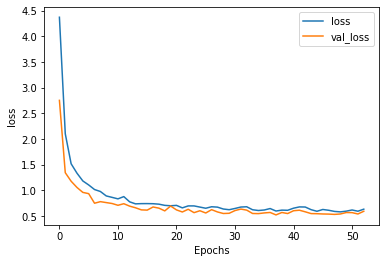

In [42]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

## 3.2. Result Interpretation and Evaluation

Here we evaluate on `y_test`, which we made sure earlier comes from a similar distribution within the training set itself. 

Resulted on a pretty confident `mae` and `mse`, which I would say a good result considering the number of classes we have.

In [43]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 3s 732us/step - loss: 0.5554 - mae: 0.3816
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 55.54%
mae: 38.16%


We can also print classification report from each column.

In [44]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
  print("Column", df.columns[1:][i])
  estimates = [round(float(x)) for x in y_pred[:,i]]
  estimates = transform_results(estimates)
  print(np.unique(estimates))
  print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.94      0.90      0.92       462
         2.0       0.76      0.68      0.72       482
         3.0       0.61      0.65      0.63       510
         4.0       0.60      0.66      0.63       517
         5.0       0.60      0.65      0.63       467
         6.0       0.73      0.63      0.67       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.71      3360
   macro avg       0.72      0.71      0.72      3360
weighted avg       0.72      0.71      0.71      3360
 
------
Column complicated<==>easy
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.94      0.90      0.92       463
         2.0       0.76      0.72      0.74       485
         3.0       0.62      0.66      0.64       501
         4.0       0.62      0.67      0.64       515
         5.0       0.66      0.7

## 3.3. Prepare the Plotting Set

Due to the multi-dimensional nature of our results and test set, we need to reshape the predictions by using `numpy`'s `flatten()` attribute, which flattens the array column-wise if we specify the argument `order='F'` to flatten in Fortran-style order.

Keep in mind this will indeed aggregate the metrics like on the `classification_report()` below.

In [45]:
y_pred_flattened = y_pred.flatten(order='F')
y_test_flattened = y_test.flatten(order='F')
y_classified = [round(float(x)) for x in y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 1, 3, 1, 4, 3, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.95      0.92      0.94      3691
         2.0       0.79      0.73      0.76      3921
         3.0       0.65      0.70      0.67      3952
         4.0       0.70      0.74      0.72      4161
         5.0       0.75      0.78      0.77      3786
         6.0       0.85      0.79      0.82      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.79     26880
   macro avg       0.80      0.80      0.80     26880
weighted avg       0.80      0.79      0.79     26880



In [46]:
# Wrapper function(s) from earlier notebook
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
  """
  Modified function behavior, now predicts column-wise
  """
  y_score = clf.predict_proba(X_test)
  target_names = np.unique(y_test)
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # calculate dummies once
  y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
  print(y_test_dummies.shape, y_score.shape)
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic')
    
  for i in range(len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

def plot_multiclass_roc_LSTM(X_test, y_test, n_classes, figsize=(17, 6), model=model):
  """
  Custom-made function to plot ROC curve.
  Sorry I can't run because I don't have the excel file used for this particular notebook.
  """
  y_score = to_categorical(y_test)
  target_names = ["obstructive vs supportive",
                  "complicated vs easy",
                  "inefficient vs efficient",
                  " confusing vs clear",
                  "boring vs exciting",
                  "not interesting vs interesting",
                  "conventional vs inventive",
                  "usual vs leading edge"]
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # One-liner transformation of our existing result 
  y_test_dummies = np.pad(pd.get_dummies(y_classified, drop_first=False).values, 
                          ((0,0), 
                           (min(labels.flatten()),0)))
  print(y_test_dummies.shape, y_score.shape) # Quick debug purposes after one-hot encoding
                                             # to ensure matrix dimension is right
  for i in range(1, n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Column-wise Receiver Operating Characteristic Plot')
    
  for i in range(1, len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()


# plot_multiclass_roc_LSTM(X_test, y_classified, 8, figsize=(17, 6))

ROC AUC score: 0.8785244740964995


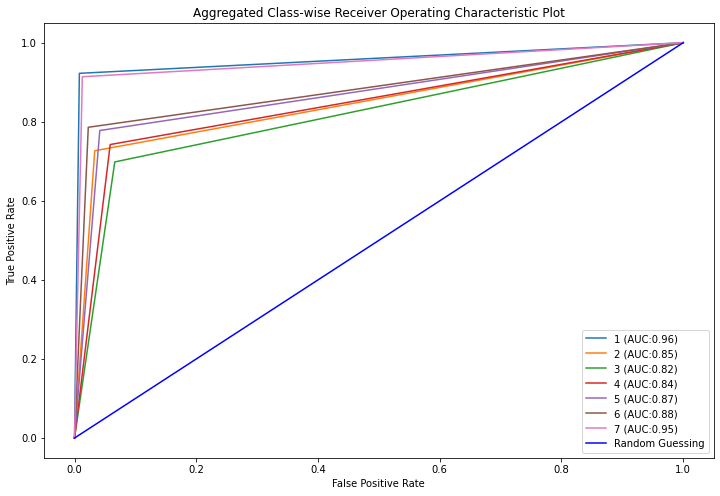

In [47]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(set(labels.flatten())):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test_flattened, y_classified))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('Aggregated Class-wise Receiver Operating Characteristic Plot')
plt.savefig("auc.png")
plt.show()

## 3.4. Exporting the Model

We can export the model to `HDF5` format designed to store large amounts of information. More info:
* [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
* [TensorFlow Documentation](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format)

In [25]:
model.save('UX_Regression.h5')

## 3.5. XGB Method
For comparison, we try implementing XGB.

For column: obstructive<==>supportive
[19:44:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.88      0.86       482
         3.0       0.74      0.74      0.74       510
         4.0       0.67      0.65      0.66       517
         5.0       0.65      0.66      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [ 

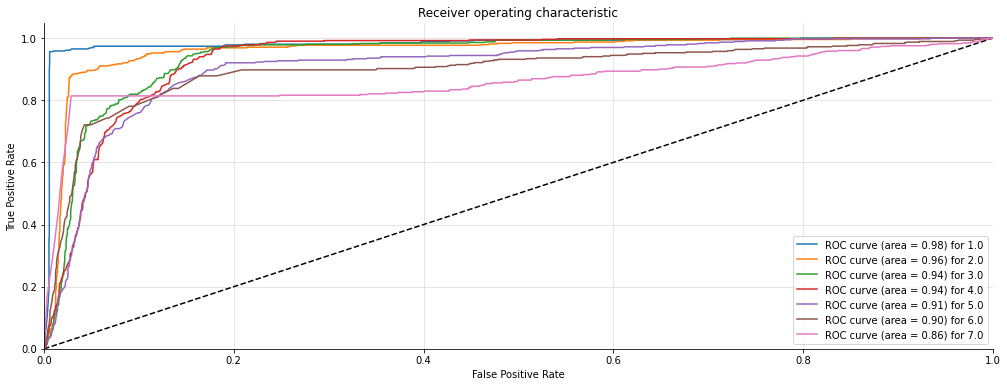

For column: complicated<==>easy
[19:44:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.83      0.87      0.85       485
         3.0       0.73      0.73      0.73       501
         4.0       0.67      0.66      0.67       515
         5.0       0.70      0.71      0.71       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 424

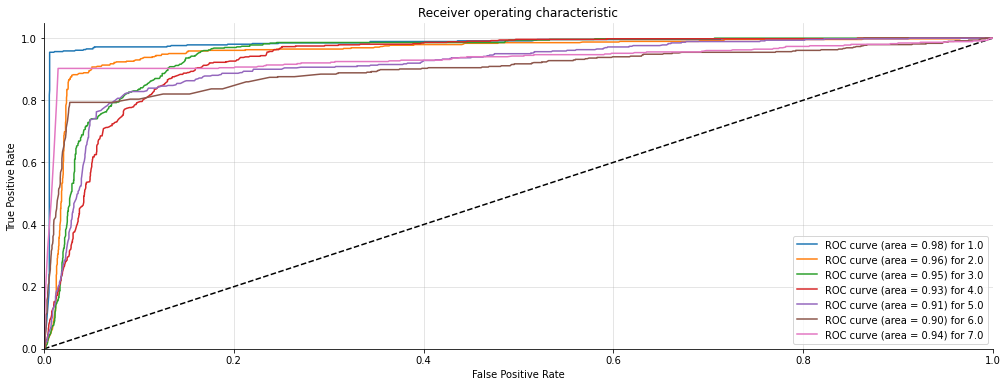

For column: inefficient<==>efficient
[19:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.86       482
         3.0       0.72      0.73      0.73       506
         4.0       0.67      0.63      0.65       526
         5.0       0.65      0.67      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  

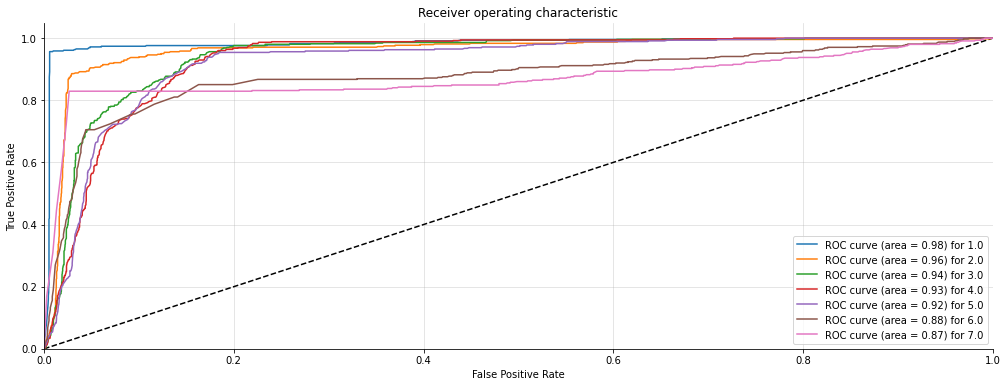

For column:  confusing<==>clear
[19:44:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.83      0.87      0.85       488
         3.0       0.74      0.72      0.73       506
         4.0       0.66      0.66      0.66       516
         5.0       0.65      0.67      0.66       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 426

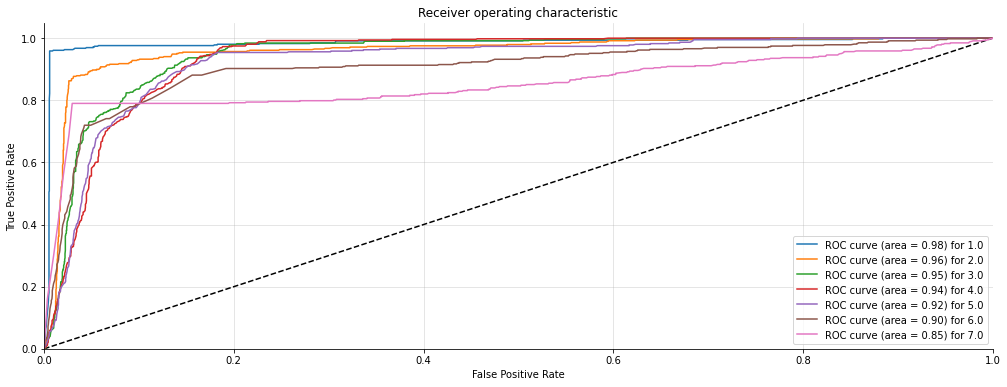

For column: boring<==>exciting
[19:44:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.87       491
         3.0       0.82      0.82      0.82       487
         4.0       0.86      0.86      0.86       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 430 

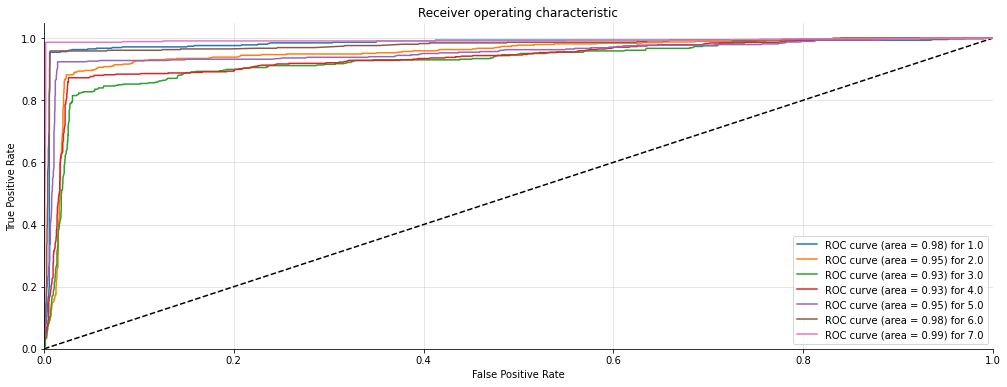

For column: not interesting<==>interesting
[19:44:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.86      0.86       495
         3.0       0.81      0.78      0.80       490
         4.0       0.83      0.84      0.83       519
         5.0       0.88      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0

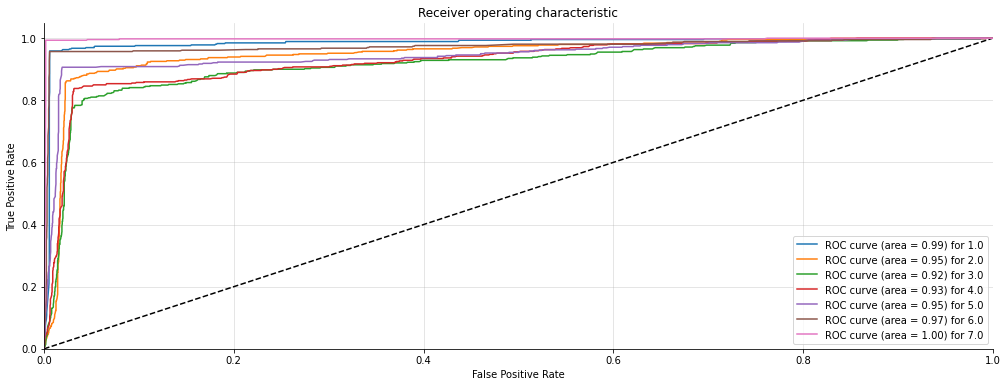

For column: conventional<==>inventive
[19:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.97      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [ 

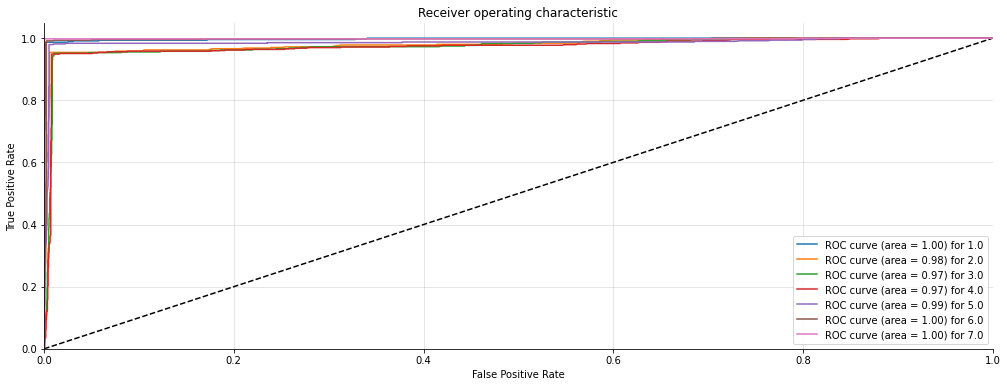

For column: usual<==>leading edge
[19:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 4

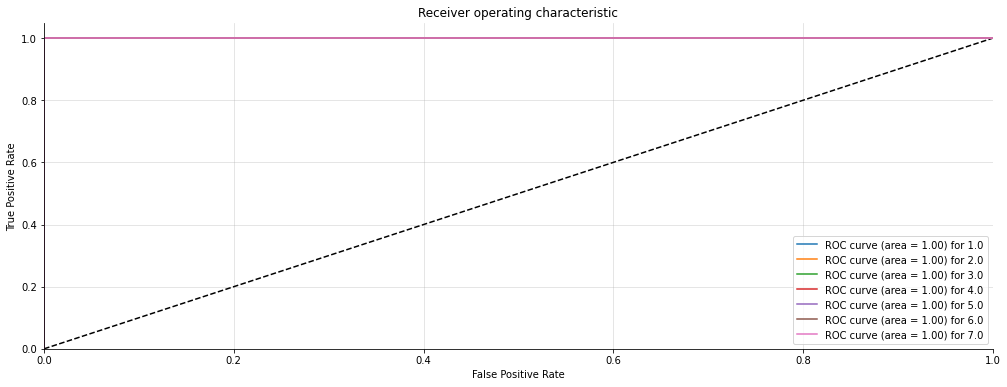

In [57]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
def XGBmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    xgb_classifier = XGBClassifier()
    xgb_classifier.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in xgb_classifier.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(xgb_classifier, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  XGBmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))


In [58]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.8613467261904761
average Precision :0.8611220605590124
average Recall :0.8613467261904761
average F1 -score :0.861147606858929


## 3.6. SVM Method

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.48      0.92      0.63       462
         2.0       0.67      0.58      0.62       482
         3.0       0.63      0.42      0.50       510
         4.0       0.58      0.41      0.48       517
         5.0       0.53      0.44      0.48       467
         6.0       0.60      0.64      0.62       470
         7.0       0.78      0.81      0.80       452

    accuracy                           0.60      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[427  11   4   5   0   7   8]
 [112 279  38  20  10  18   5]
 [113  47 212  85  26  25   2]
 [ 84  32  39 214 120  26   2]
 [ 87  15  19  28 205 113   0]
 [ 41  14   9  10  12 299  85]
 [ 21  17  15  10  12   9 368]]
Accuracy Score : 0.5964285714285714
Precision Score : 0.610558571644958
Recall Score : 0.5964285714285714
F1 Score : 0.58733706

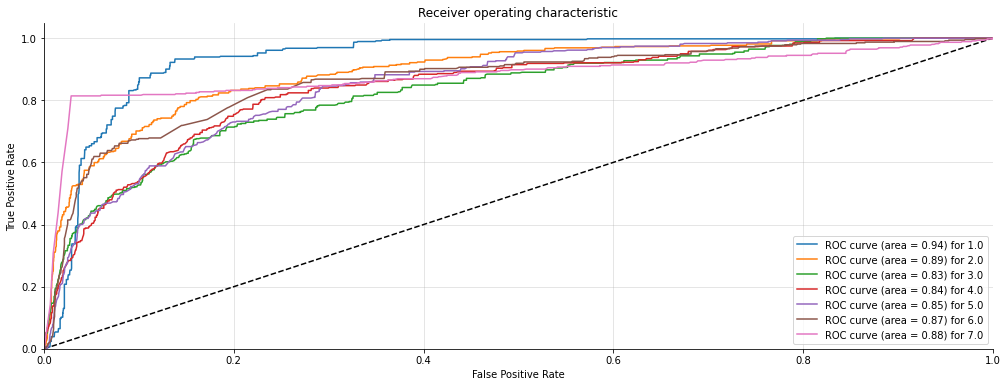

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.48      0.92      0.63       463
         2.0       0.68      0.56      0.61       485
         3.0       0.64      0.41      0.50       501
         4.0       0.60      0.44      0.51       515
         5.0       0.58      0.50      0.53       460
         6.0       0.69      0.71      0.70       484
         7.0       0.88      0.90      0.89       452

    accuracy                           0.63      3360
   macro avg       0.65      0.63      0.62      3360
weighted avg       0.65      0.63      0.62      3360

Confusion Matrix: 
 [[427  11   4   5   0   8   8]
 [120 272  38  20  16  18   1]
 [109  50 207  88  27  18   2]
 [ 81  33  40 225 110  24   2]
 [ 93  14  20  20 229  84   0]
 [ 50  10  12  14  10 344  44]
 [ 16  12   4   3   6   3 408]]
Accuracy Score : 0.6285714285714286
Precision Score : 0.6463786716896139
Recall Score : 0.6285714285714286
F1 Score : 0.6209574555607

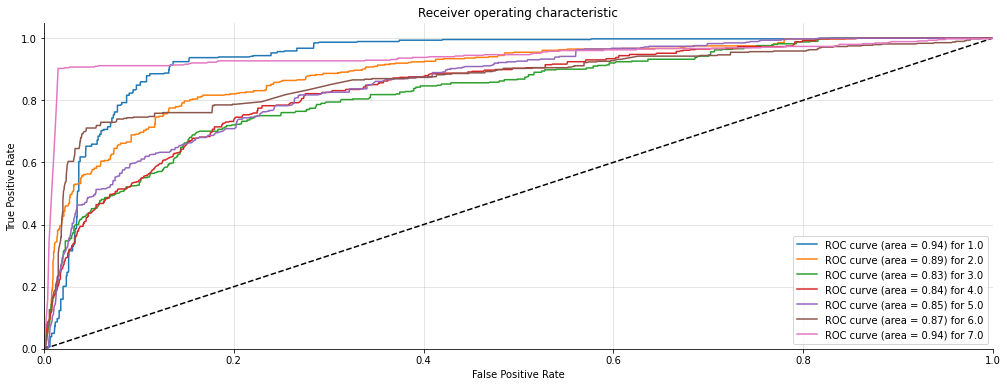

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.48      0.92      0.63       462
         2.0       0.68      0.58      0.63       482
         3.0       0.61      0.41      0.49       506
         4.0       0.56      0.39      0.46       526
         5.0       0.53      0.44      0.48       458
         6.0       0.61      0.63      0.62       475
         7.0       0.79      0.83      0.81       451

    accuracy                           0.59      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.59      0.58      3360

Confusion Matrix: 
 [[426  11   4   5   0   8   8]
 [115 280  40  18  10  15   4]
 [111  46 208  92  25  21   3]
 [ 86  37  48 207 118  26   4]
 [ 89   9  12  28 203 117   0]
 [ 44  12  14  12  16 298  79]
 [ 21  18  14   9   9   6 374]]
Accuracy Score : 0.594047619047619
Precision Score : 0.60718213080253
Recall Score : 0.594047619047619
F1 Score : 0.584543604725

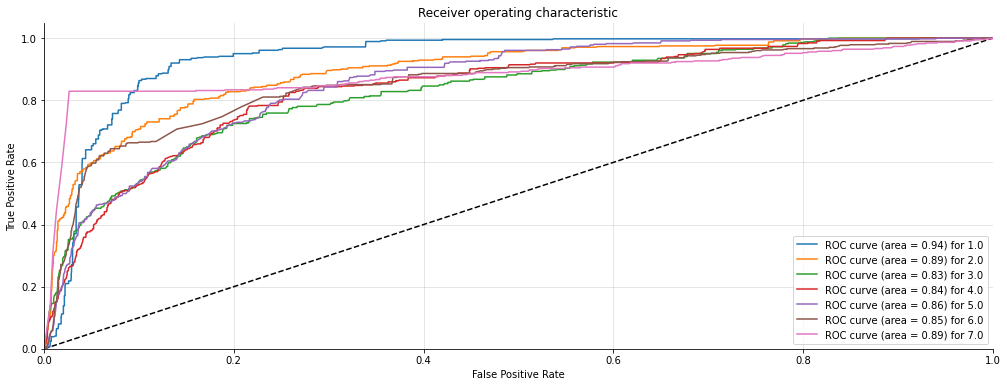

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.48      0.93      0.63       461
         2.0       0.70      0.56      0.62       488
         3.0       0.64      0.42      0.51       506
         4.0       0.57      0.41      0.48       516
         5.0       0.52      0.45      0.48       456
         6.0       0.62      0.64      0.63       471
         7.0       0.78      0.79      0.79       462

    accuracy                           0.60      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[429  10   4   5   0   5   8]
 [123 275  34  20  13  18   5]
 [109  46 213  88  31  16   3]
 [ 84  28  39 213 123  25   4]
 [ 83   7  15  31 207 113   0]
 [ 44  10  12   6  13 300  86]
 [ 28  19  17  13  11   7 367]]
Accuracy Score : 0.5964285714285714
Precision Score : 0.6137084512959193
Recall Score : 0.5964285714285714
F1 Score : 0.5884787921087

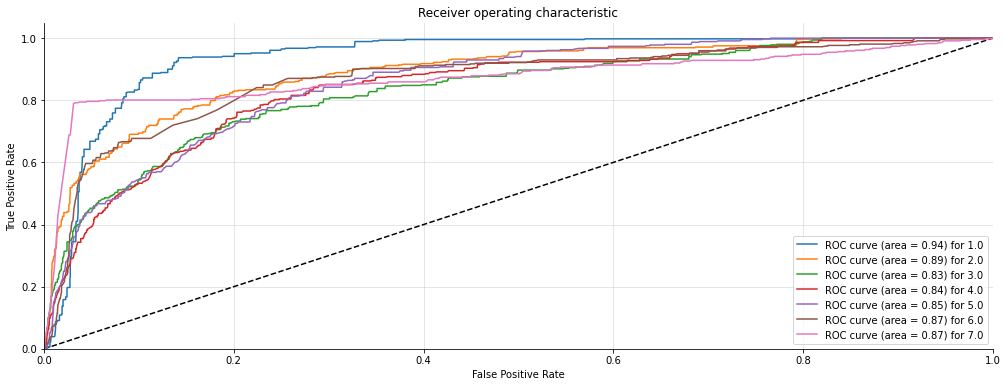

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.49      0.90      0.63       463
         2.0       0.73      0.56      0.64       491
         3.0       0.70      0.51      0.59       487
         4.0       0.72      0.55      0.62       518
         5.0       0.76      0.62      0.69       487
         6.0       0.77      0.88      0.82       462
         7.0       0.96      0.99      0.97       452

    accuracy                           0.71      3360
   macro avg       0.73      0.72      0.71      3360
weighted avg       0.73      0.71      0.71      3360

Confusion Matrix: 
 [[416   8   9   6   0  16   8]
 [117 276  43  21  14  19   1]
 [107  37 247  60  17  18   1]
 [ 76  38  32 284  59  25   4]
 [ 94  16  19  17 303  38   0]
 [ 39   2   4   2   3 407   5]
 [  0   0   0   2   1   3 446]]
Accuracy Score : 0.7080357142857143
Precision Score : 0.7333657822474762
Recall Score : 0.7080357142857143
F1 Score : 0.70517998934766

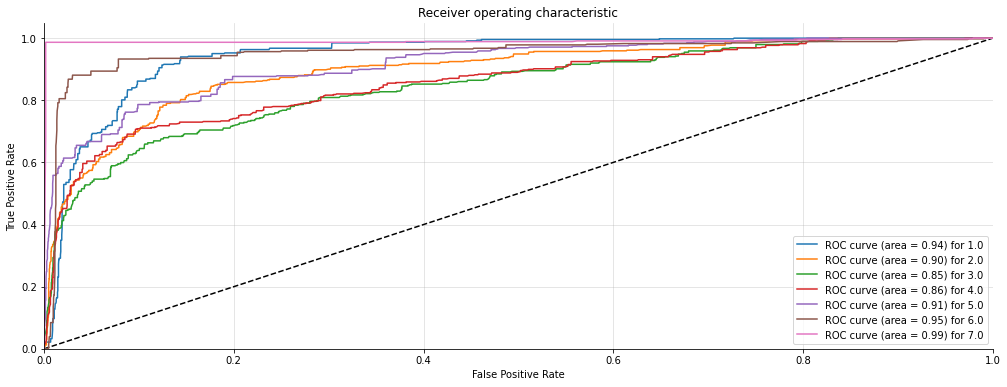

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.48      0.89      0.63       461
         2.0       0.72      0.55      0.62       495
         3.0       0.67      0.47      0.55       490
         4.0       0.70      0.54      0.61       519
         5.0       0.75      0.62      0.68       481
         6.0       0.77      0.88      0.82       465
         7.0       0.96      0.99      0.98       449

    accuracy                           0.70      3360
   macro avg       0.72      0.70      0.70      3360
weighted avg       0.72      0.70      0.69      3360

Confusion Matrix: 
 [[409   9   9   6   5  15   8]
 [119 271  43  26  17  18   1]
 [106  48 229  64  18  24   1]
 [ 76  39  38 278  56  28   4]
 [ 95   8  22  21 300  35   0]
 [ 39   2   3   2   6 408   5]
 [  0   0   0   2   0   1 446]]
Accuracy Score : 0.6967261904761904
Precision Score : 0.7188304708358527
Recall Score : 0.6967261904761904
F1 Score : 0.69

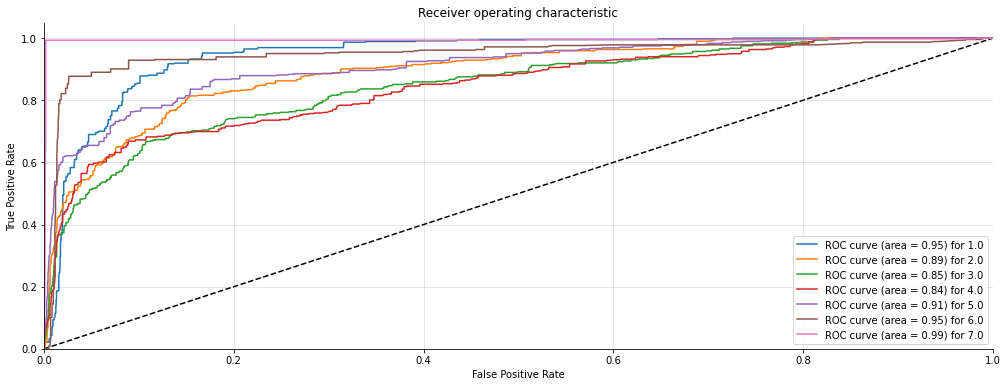

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.65       460
         2.0       0.81      0.60      0.69       502
         3.0       0.76      0.61      0.68       474
         4.0       0.82      0.60      0.69       527
         5.0       0.80      0.67      0.73       486
         6.0       0.81      0.91      0.86       459
         7.0       0.97      1.00      0.98       452

    accuracy                           0.75      3360
   macro avg       0.78      0.76      0.76      3360
weighted avg       0.78      0.75      0.75      3360

Confusion Matrix: 
 [[420   3  14   5   0  10   8]
 [117 302  28  21  16  17   1]
 [ 93  32 289  26  19  14   1]
 [ 72  28  36 317  44  26   4]
 [ 97   6  11  18 327  27   0]
 [ 39   0   0   0   2 418   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.7511904761904762
Precision Score : 0.7842752905730127
Recall Score : 0.7511904761904762
F1 Score : 0.7520950

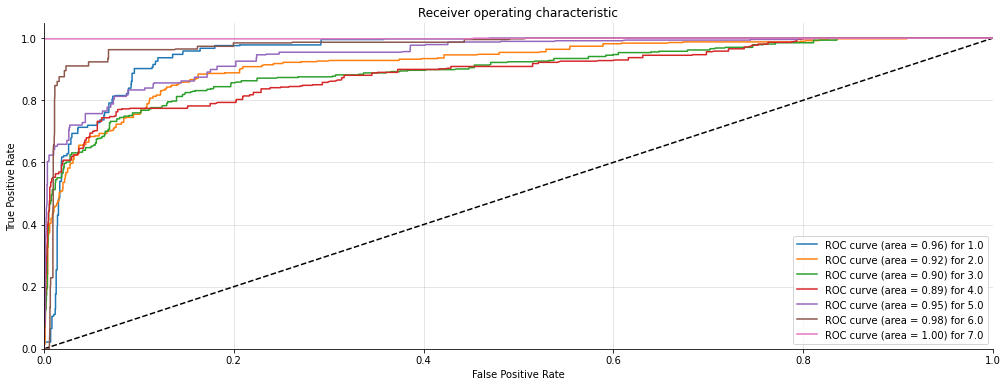

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.50      0.93      0.65       459
         2.0       0.84      0.62      0.72       496
         3.0       0.80      0.65      0.72       478
         4.0       0.87      0.63      0.73       523
         5.0       0.82      0.67      0.74       491
         6.0       0.83      0.92      0.87       462
         7.0       0.97      1.00      0.99       451

    accuracy                           0.77      3360
   macro avg       0.81      0.78      0.77      3360
weighted avg       0.81      0.77      0.77      3360

Confusion Matrix: 
 [[425   0   9   6   0  10   9]
 [116 310  18  20  15  17   0]
 [ 99  23 312  13  19  12   0]
 [ 67  31  32 332  36  21   4]
 [100   6  17  11 329  28   0]
 [ 37   0   0   0   0 425   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.7690476190476191
Precision Score : 0.8070199797815771
Recall Score : 0.7690476190476191
F1 Score : 0.77174101478

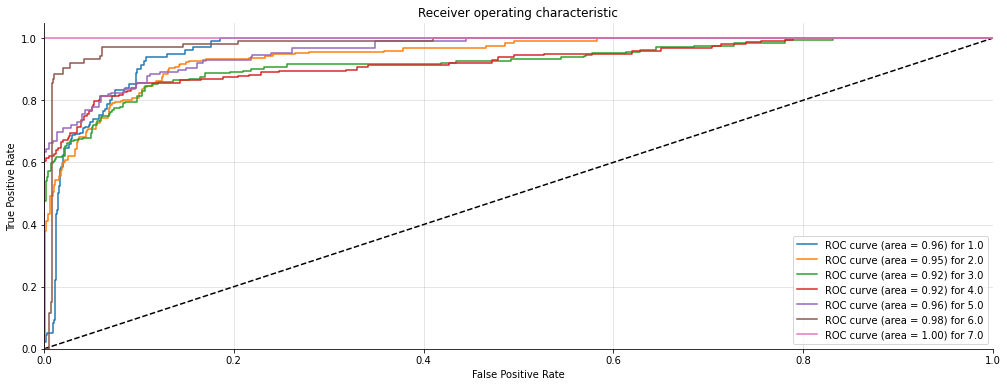

In [59]:
acc=[]
pre=[]
recal=[]
f1=[]
def SVMmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    svc = SVC( probability=True)
    svc.fit(X_train, y_train)

    # predictions over test set
    predictions=[round(float(x)) for x in svc.predict(X_test)]
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(svc, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  SVMmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [60]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.6675595238095238
average Precision :0.6901649186088674
average Recall :0.6675595238095238
average F1 -score :0.6628551640563973


## 3.7. Custom-Built Ordinal Classifier

Credit: [Muhammad for Towards Data Science](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)

Ordinal classifier basically does a similar thing to one-hot encoding -- but despite having one value each column, ordinal encoding maps unique binary values for each of our unique classes.

We implement a custom object called `OrdinalClassifier` built on top of any `sklearn` model that supports the `predict_proba()` function; ranging from Naive Bayes to decision trees.

Last implementation, we deduced the labels by one, from `[1,2,3,4,5,6,7]` to `[0,1,2,3,4,5,6]` due to the nature of zero-indexing of standard sklearn library. But this doesn't work if the labels aren't ranging fully from 1 to 7 -- could be 2 to 6 or 2 to 7 instead.

So the solution is to change the overall behavior of the `OrdinalClassifier` object to take maximum class (e.g. 7) and minimum class (e.g. 2 or 3) into consideration. From there, we simulate the `np.argmax()` function to be added the minimum class before being returned. We also add the minimum class as an index towards `self.clfs` dictionary when adding new value, so we don't need to deduce the labels by hand. In other words, labels stay as-is instead of being deduced by 1 :)

This also changes how the approach for ordinal encoding works -- instead of `k - 1` like the author's original implementation, we feed `k` numbers of encoding because our labels are already one-indexed.

Keep in mind that the `predict_proba()` function does not yet implement this change, because it's only a wrapper function before eventually calling `predict()` in which we care the most about the result. 

For column: obstructive<==>supportive
[19:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:08] WARNING: C:/Users/Adm

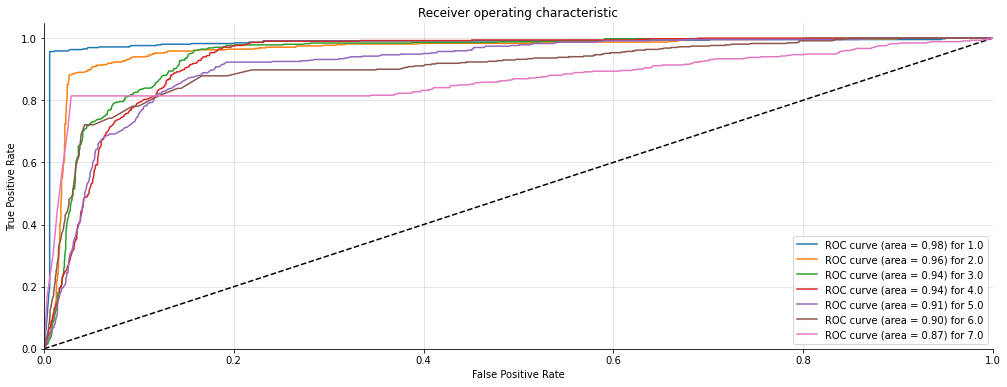

For column: complicated<==>easy
[19:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:10] WARNING: C:/Users/Administr

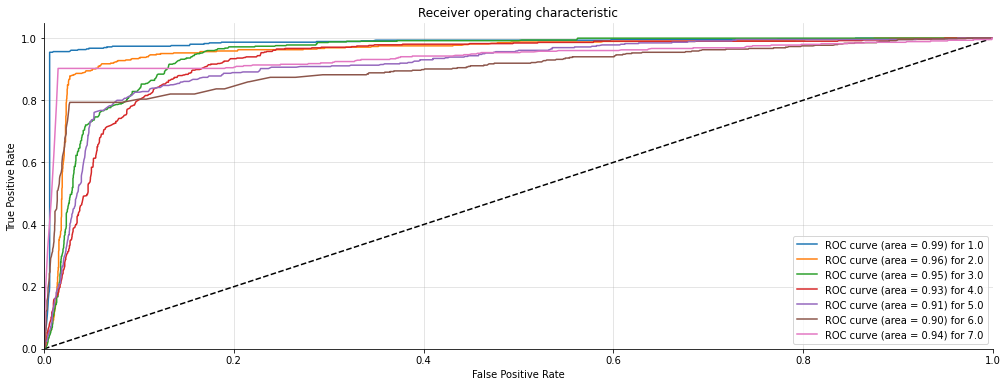

For column: inefficient<==>efficient
[19:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:13] WARNING: C:/Users/Admi

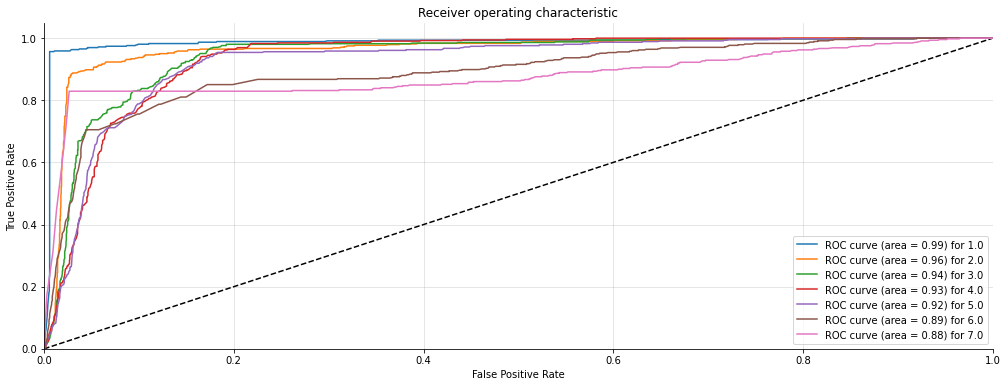

For column:  confusing<==>clear
[19:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:15] WARNING: C:/Users/Administr

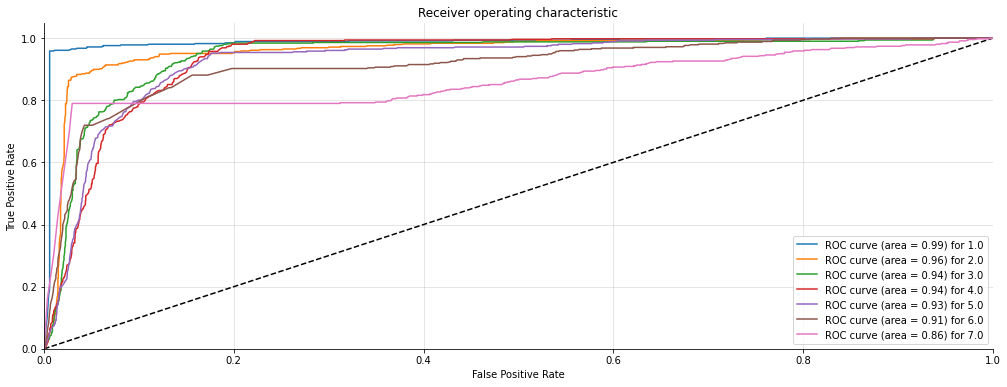

For column: boring<==>exciting
[19:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:17] WARNING: C:/Users/Administra

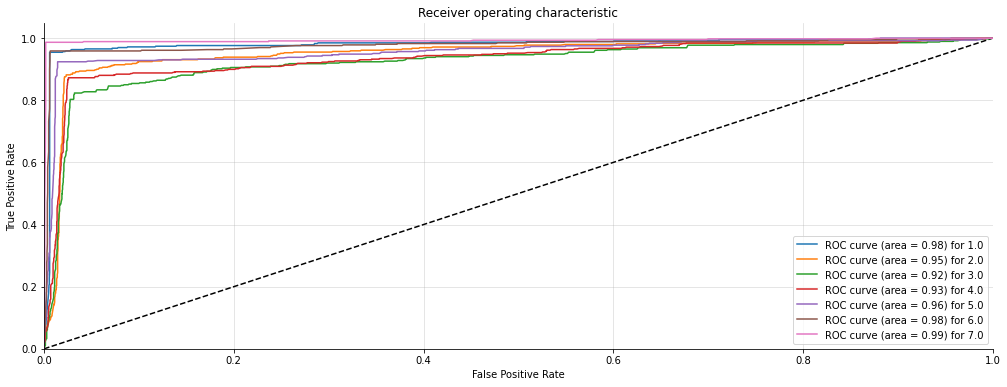

For column: not interesting<==>interesting
[19:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:19] WARNING: C:/User

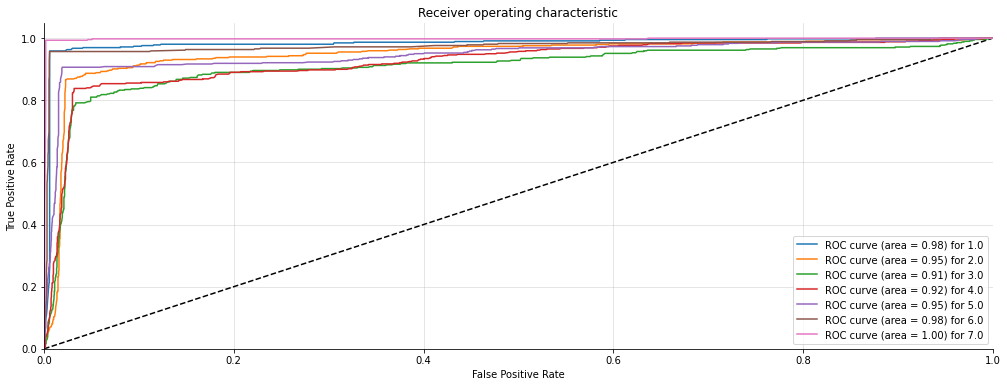

For column: conventional<==>inventive
[19:51:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:21] WARNING: C:/Users/Adm

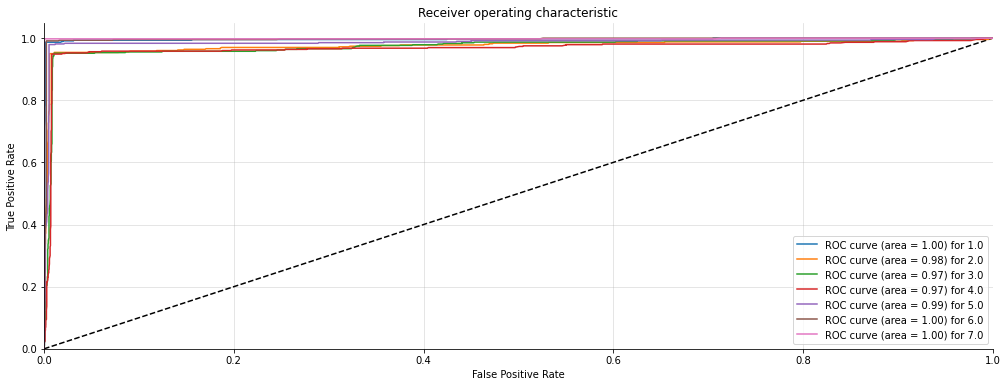

For column: usual<==>leading edge
[19:51:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:51:23] WARNING: C:/Users/Adminis

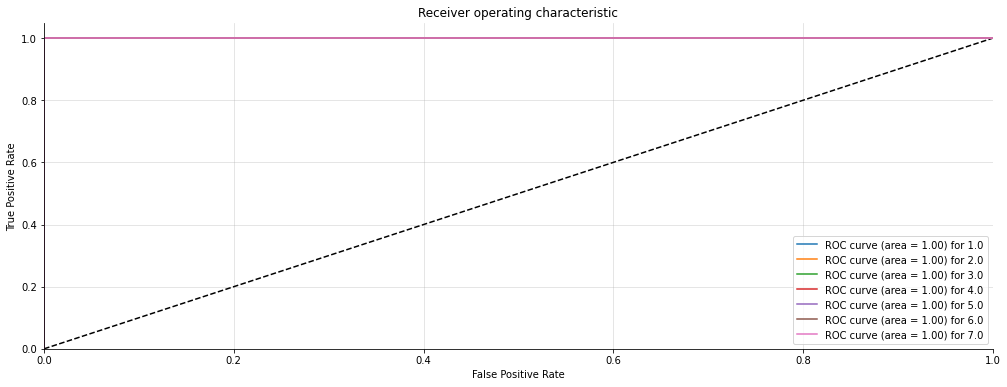

In [61]:
from sklearn.base import clone

acc=[]
pre=[]
recal=[]
f1=[]
class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        self.max_class = max(self.unique_class)
        self.min_class = min(self.unique_class)
        if self.unique_class.shape[0] > 2:
            # print(self.unique_class.shape[0]) # Uncomment to debug
            for i in range(self.unique_class.shape[0]):
                # for each k ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                
                
                clf.fit(X, binary_y)
                self.clfs[i + self.min_class] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        # print(self.clfs) # Uncomment to debug
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1) + self.min_class

def OrdinalModel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    clf = OrdinalClassifier(XGBClassifier()) # Using XGB as the placeholder model 
    clf.fit(X_train, y_train)

    # predictions over test set
    predictions = clf.predict(X_test)
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))

    plot_multiclass_roc(clf, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  OrdinalModel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))
  #break # Uncomment to debug

In [62]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.8618303571428572
average Precision :0.8615950937383932
average Recall :0.8618303571428572
average F1 -score :0.8616238686097641


# 4. Other Deep Learning Model(s)

## 4.1. Bidirectional LSTM

In [29]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=['mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 520       
Total params: 202,824
Trainable params: 202,824
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 4s 111ms/step - loss: 17.3786 - mae: 3.6129 - val_loss: 6.9256 - val_mae: 2.1382
Epoch 2/100
21/21 [==============================] - 2s 83ms/step - loss: 5.9656 - mae: 1.9973 - val_loss: 4.1065 - val_mae: 1.7242
Epoch 3/100
21/21 [==============================] - 2s 86ms/step - loss: 4.8817 - mae: 1.8327 - val_loss: 3.5179 - val_mae: 1.5868
Epoch 4/100
21/21 [==============================] - 2s 78ms/step - loss: 3.7463 - mae: 1.5529 - val_loss: 1.9785 - val_mae: 1.0942
Epoch 5/100
21/21 [==============================] - 2s 76ms/step - loss: 2.2927 - mae: 1.1546 - val_loss: 1.2312 - val_mae: 0.8155
Epoch 6/100
21/21 [==============================] - 2s 75ms/step - loss: 1.8378 - mae: 1.0103 - val_loss: 1.0594 - val_mae: 0.7190
Epoch 7/100
21/21 [==============================] - 2s 75ms/step - loss: 1.6246 - mae: 0.9252 - val_loss: 0.8861 - val_mae: 0.5940
Epoch 8/100
21/21 [==============================] - 2s 74ms/step - loss: 

### 4.1.1. Interpretation

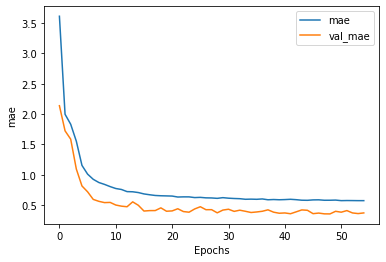

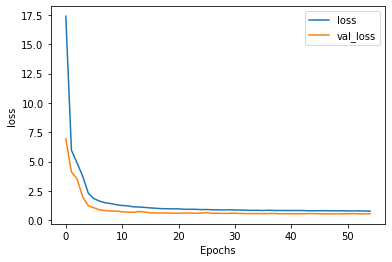

In [31]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [32]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 9s 3ms/step - loss: 0.5464 - mae: 0.3747
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 54.64%
mae: 37.47%


In [33]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 1, 2, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.94      0.95      0.95      3691
         2.0       0.84      0.75      0.79      3921
         3.0       0.72      0.72      0.72      3952
         4.0       0.73      0.80      0.76      4161
         5.0       0.79      0.80      0.79      3786
         6.0       0.87      0.85      0.86      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.82     26880
   macro avg       0.83      0.83      0.83     26880
weighted avg       0.83      0.82      0.82     26880



## 4.2. BERT [deprecated]

In [34]:
"""!pip install -q -U tensorflow-text
!pip install -q tf-models-official
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

to_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
to_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_model = hub.KerasLayer(to_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_model(text_test)

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {to_handle}')
history = classifier_model.fit(X_train, y_train)"""

"!pip install -q -U tensorflow-text\n!pip install -q tf-models-official\nimport tensorflow_hub as hub\nimport tensorflow_text as text\nfrom official.nlp import optimization  # to create AdamW optimizer\n\nto_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'\nto_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'\nbert_model = hub.KerasLayer(to_preprocess)\n\ntext_test = ['this is such an amazing movie!']\ntext_preprocessed = bert_model(text_test)\n\ndef build_classifier_model():\n  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')\n  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')\n  encoder_inputs = preprocessing_layer(text_input)\n  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(1, activation=None, name='classifi

# RBFN

In [35]:

from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

In [36]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        print("done")
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [37]:
import numpy as np, pandas as pd
from keras.models import Sequential 
from keras.layers.core import Dense
from keras.layers import Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [38]:
model = Sequential()
rbflayer = RBFLayer(100,
                        initializer=InitCentersKMeans(X_train),
                        betas=3.0,
                        input_shape=(X_train.shape[1],))
model.add(rbflayer)
model.add(Dense(8))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['accuracy'])
model.build(X_train.shape)
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (13440, 100)              2100      
_________________________________________________________________
dense (Dense)                (13440, 8)                808       
_________________________________________________________________
activation (Activation)      (13440, 8)                0         
Total params: 2,908
Trainable params: 2,908
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
420/420 [==============================] - 15s 2ms/step - loss: 19.4319 - accuracy: 0.2287
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 16.3813 - accuracy: 0.0404
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 13.6450 - accuracy: 0.0123
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - los

In [39]:
y_train.shape

(13440, 8)

In [40]:
LSTM_y_pred = model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [[2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [4. 4. 4. 4. 5. 5. 5. 5.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [7. 7. 7. 7. 2. 2. 1. 1.]]
Predicted labels: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      3691
         2.0       0.00      0.00      0.00      3921
         3.0       0.82      0.01      0.02      3952
         4.0       0.16      1.00      0.27      4161
         5.0       0.82      0.03      0.06      3786
         6.0       0.86      0.04      0.08      3748
         7.0       0.00      0.00      0.00      3621

    accuracy                           0.17     26880
   macro avg       0.38      0.15      0.06     26880
weighted avg       0.38      0.17      0.07     268

In [41]:
from sklearn.metrics import classification_report

In [42]:
X_test.shape

(3360, 20)

In [43]:
y_test.shape

(3360, 8)

# Multiclass Logistic regression

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.23      0.52      0.32       462
         2.0       0.26      0.21      0.23       482
         3.0       0.23      0.10      0.14       510
         4.0       0.27      0.16      0.20       517
         5.0       0.24      0.13      0.17       467
         6.0       0.18      0.14      0.16       470
         7.0       0.49      0.85      0.62       452

    accuracy                           0.29      3360
   macro avg       0.27      0.30      0.26      3360
weighted avg       0.27      0.29      0.26      3360

Confusion Matrix: 
 [[240  33  34  22  17  53  63]
 [153 101  35  41  46  45  61]
 [140  79  52  65  41  78  55]
 [152  70  45  84  49  52  65]
 [176  46  35  53  61  57  39]
 [160  43  19  38  31  67 112]
 [ 26  12   8   5   5  14 382]]
Accuracy Score : 0.29375
Precision Score : 0.2714879320005425
Recall Score : 0.29375
F1 Score : 0.259618219437591
(3360, 7) (33

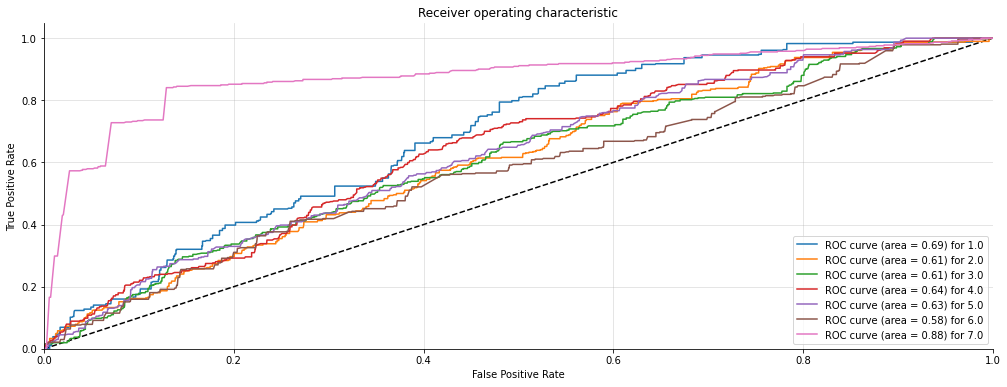

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.25      0.22      0.23       463
         2.0       0.23      0.18      0.20       485
         3.0       0.22      0.15      0.18       501
         4.0       0.25      0.22      0.23       515
         5.0       0.20      0.19      0.20       460
         6.0       0.22      0.25      0.23       484
         7.0       0.54      0.92      0.68       452

    accuracy                           0.30      3360
   macro avg       0.27      0.30      0.28      3360
weighted avg       0.27      0.30      0.27      3360

Confusion Matrix: 
 [[101  54  41  47  58  82  80]
 [ 55  85  65  88  69  66  57]
 [ 39  64  77  86  88  93  54]
 [ 57  53  71 112  85  90  47]
 [ 61  70  60  61  89  85  34]
 [ 94  39  38  50  55 120  88]
 [  5   7   4  11   3   7 415]]
Accuracy Score : 0.29732142857142857
Precision Score : 0.2678697358666748
Recall Score : 0.29732142857142857
F1 Score : 0.27416251122

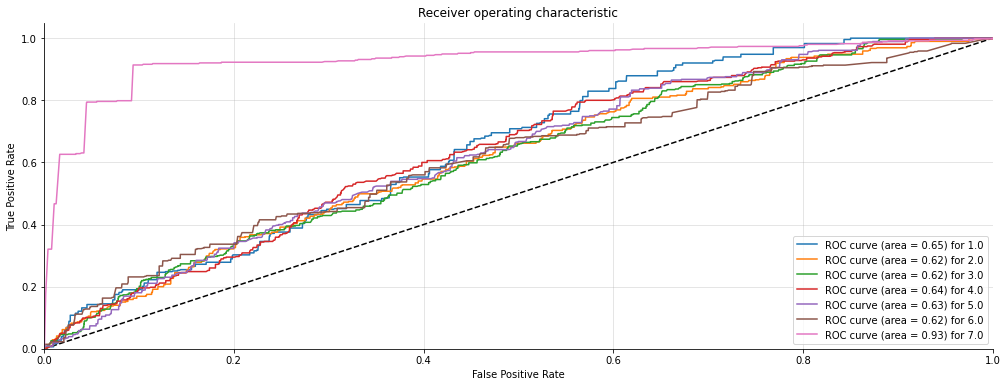

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.23      0.52      0.32       462
         2.0       0.25      0.19      0.21       482
         3.0       0.22      0.10      0.13       506
         4.0       0.27      0.13      0.17       526
         5.0       0.22      0.14      0.17       458
         6.0       0.19      0.15      0.17       475
         7.0       0.47      0.85      0.61       451

    accuracy                           0.29      3360
   macro avg       0.26      0.30      0.25      3360
weighted avg       0.26      0.29      0.25      3360

Confusion Matrix: 
 [[240  33  34  18  17  53  67]
 [155  90  35  36  48  47  71]
 [143  72  49  49  56  75  62]
 [157  74  45  66  55  65  64]
 [167  47  32  44  62  60  46]
 [160  40  18  34  33  73 117]
 [ 28  11  10   2   7   9 384]]
Accuracy Score : 0.2869047619047619
Precision Score : 0.262162823645002
Recall Score : 0.2869047619047619
F1 Score : 0.249706415

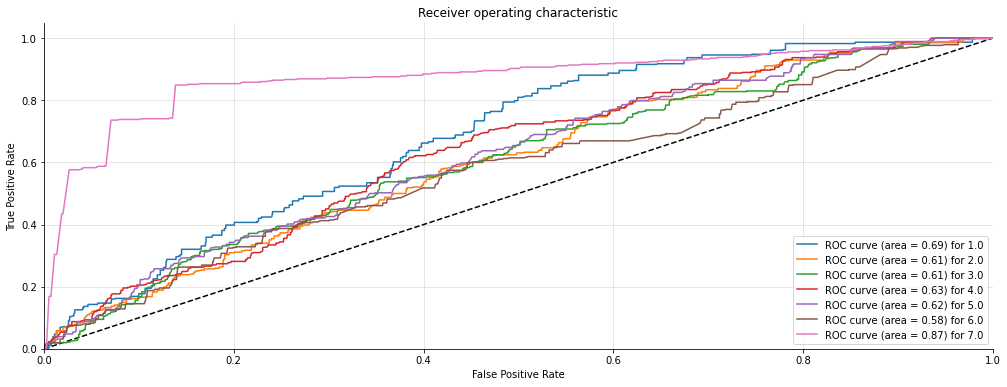

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.23      0.52      0.32       461
         2.0       0.23      0.18      0.20       488
         3.0       0.24      0.11      0.15       506
         4.0       0.30      0.14      0.19       516
         5.0       0.24      0.14      0.17       456
         6.0       0.20      0.16      0.18       471
         7.0       0.47      0.82      0.59       462

    accuracy                           0.29      3360
   macro avg       0.27      0.30      0.26      3360
weighted avg       0.27      0.29      0.26      3360

Confusion Matrix: 
 [[239  41  30  14  17  49  71]
 [166  87  37  34  49  42  73]
 [137  74  57  61  46  68  63]
 [151  68  43  74  51  63  66]
 [166  48  40  37  62  62  41]
 [157  48  19  20  32  76 119]
 [ 33  12  12   8   6  14 377]]
Accuracy Score : 0.2892857142857143
Precision Score : 0.2710540019222545
Recall Score : 0.2892857142857143
F1 Score : 0.2555651612868

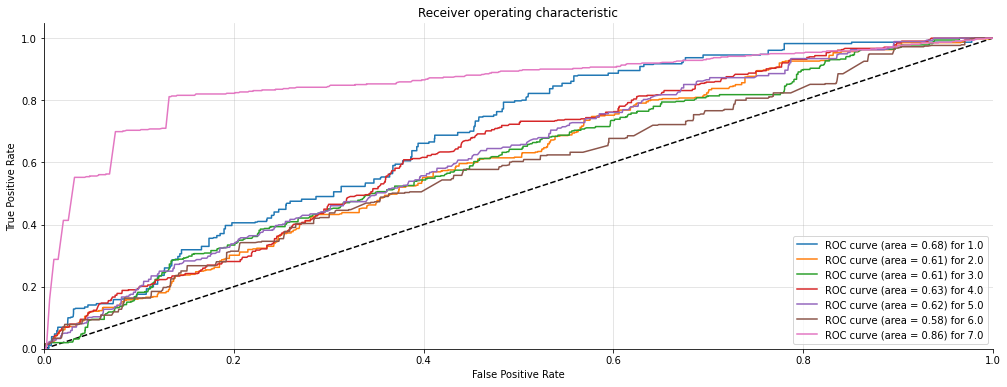

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.30      0.19      0.23       463
         2.0       0.25      0.14      0.18       491
         3.0       0.19      0.14      0.16       487
         4.0       0.25      0.19      0.22       518
         5.0       0.20      0.31      0.24       487
         6.0       0.31      0.42      0.36       462
         7.0       0.67      0.99      0.80       452

    accuracy                           0.33      3360
   macro avg       0.31      0.34      0.31      3360
weighted avg       0.31      0.33      0.31      3360

Confusion Matrix: 
 [[ 89  37  61  36  98  78  64]
 [ 34  69  57  74 141  75  41]
 [ 37  37  66  79 133  99  36]
 [ 34  40  73  99 148  96  28]
 [ 50  65  56  53 149  90  24]
 [ 53  31  29  47  78 196  28]
 [  2   1   0   1   0   1 447]]
Accuracy Score : 0.3318452380952381
Precision Score : 0.3056033180422881
Recall Score : 0.3318452380952381
F1 Score : 0.30659282746832

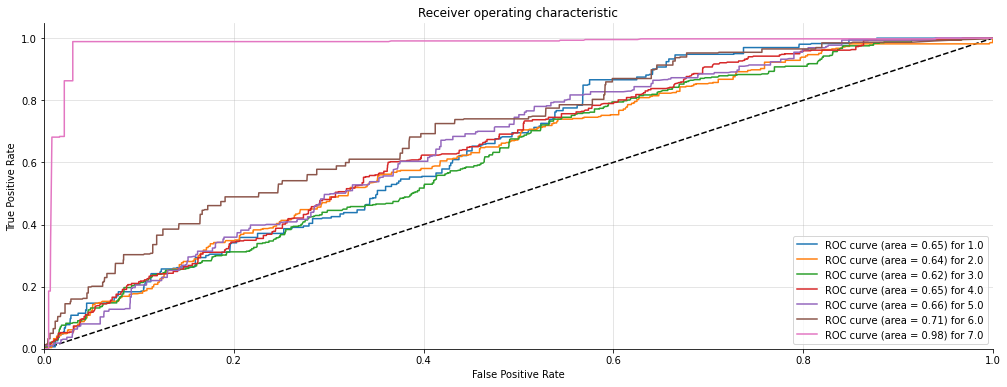

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.26      0.17      0.21       461
         2.0       0.27      0.14      0.18       495
         3.0       0.19      0.13      0.15       490
         4.0       0.23      0.19      0.21       519
         5.0       0.20      0.31      0.24       481
         6.0       0.31      0.41      0.35       465
         7.0       0.66      1.00      0.80       449

    accuracy                           0.33      3360
   macro avg       0.30      0.34      0.31      3360
weighted avg       0.30      0.33      0.30      3360

Confusion Matrix: 
 [[ 80  31  57  49 101  80  63]
 [ 36  68  58  91 130  69  43]
 [ 40  33  63  85 134  99  36]
 [ 32  41  66 100 158  89  33]
 [ 57  51  60  58 149  86  20]
 [ 63  30  29  56  64 190  33]
 [  1   0   0   0   0   1 447]]
Accuracy Score : 0.32648809523809524
Precision Score : 0.2980372076762001
Recall Score : 0.32648809523809524
F1 Score : 0.

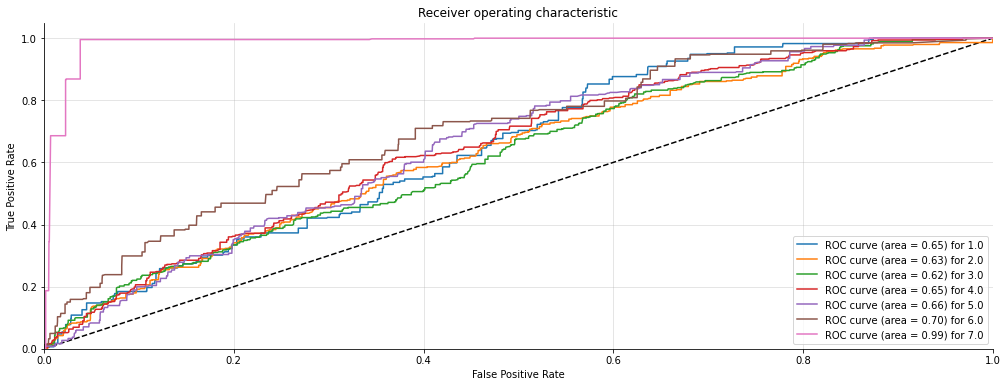

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.29      0.17      0.22       460
         2.0       0.23      0.15      0.18       502
         3.0       0.23      0.16      0.19       474
         4.0       0.23      0.17      0.20       527
         5.0       0.20      0.33      0.25       486
         6.0       0.34      0.48      0.40       459
         7.0       0.73      1.00      0.84       452

    accuracy                           0.34      3360
   macro avg       0.32      0.35      0.32      3360
weighted avg       0.32      0.34      0.32      3360

Confusion Matrix: 
 [[ 80  39  35  45 124  79  58]
 [ 39  73  59  79 142  75  35]
 [ 35  42  77  70 122 106  22]
 [ 22  63  84  89 149  97  23]
 [ 45  69  58  61 158  76  19]
 [ 51  32  29  35  80 221  11]
 [  0   0   0   1   0   0 451]]
Accuracy Score : 0.3419642857142857
Precision Score : 0.3167240682046034
Recall Score : 0.3419642857142857
F1 Score : 0.3177240

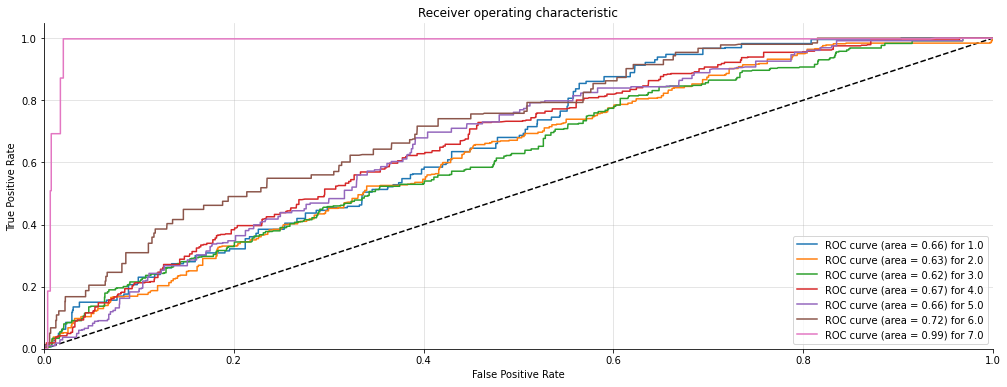

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.28      0.14      0.19       459
         2.0       0.23      0.18      0.20       496
         3.0       0.19      0.14      0.16       478
         4.0       0.28      0.22      0.24       523
         5.0       0.19      0.29      0.23       491
         6.0       0.35      0.48      0.41       462
         7.0       0.75      1.00      0.86       451

    accuracy                           0.34      3360
   macro avg       0.33      0.35      0.33      3360
weighted avg       0.32      0.34      0.32      3360

Confusion Matrix: 
 [[ 65  39  45  55 130  77  48]
 [ 30  88  64  80 131  71  32]
 [ 25  62  68  65 133 100  25]
 [ 17  70  66 114 151  91  14]
 [ 40  84  81  57 144  65  20]
 [ 53  38  29  43  66 221  12]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.3425595238095238
Precision Score : 0.32001761350086577
Recall Score : 0.3425595238095238
F1 Score : 0.3212231080

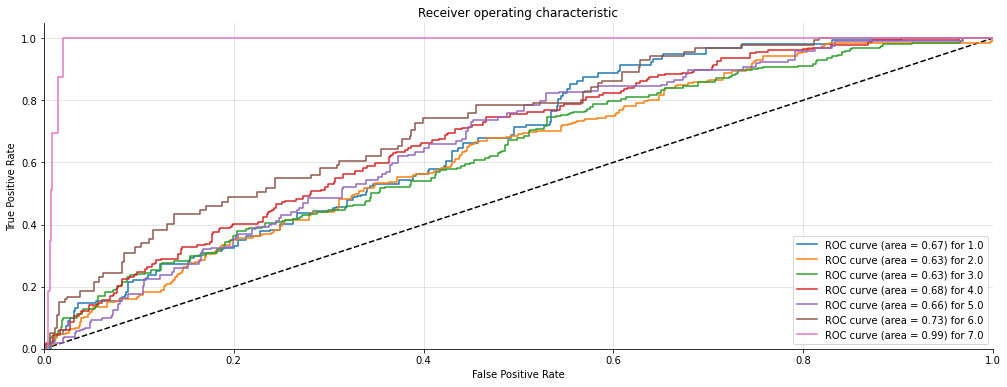

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
def Logistic(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  Logistic(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [66]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.313764880952381
average Precision :0.2891195876073039
average Recall :0.313764880952381
average F1 -score :0.2855631058213324


# Neural network - classifier

In [45]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 128)             

Epoch 1/150
588/588 - 3s - loss: 4.8711 - mae: 1.7123 - val_loss: 2.8999 - val_mae: 1.3024
Epoch 2/150
588/588 - 2s - loss: 2.7390 - mae: 1.2848 - val_loss: 1.8726 - val_mae: 1.0522
Epoch 3/150
588/588 - 2s - loss: 1.9382 - mae: 1.0678 - val_loss: 1.4785 - val_mae: 0.9101
Epoch 4/150
588/588 - 2s - loss: 1.5825 - mae: 0.9564 - val_loss: 1.3894 - val_mae: 0.9206
Epoch 5/150
588/588 - 2s - loss: 1.4122 - mae: 0.9019 - val_loss: 1.1421 - val_mae: 0.8162
Epoch 6/150
588/588 - 2s - loss: 1.2491 - mae: 0.8321 - val_loss: 1.0293 - val_mae: 0.7478
Epoch 7/150
588/588 - 2s - loss: 1.1812 - mae: 0.8006 - val_loss: 0.9015 - val_mae: 0.6650
Epoch 8/150
588/588 - 3s - loss: 1.0645 - mae: 0.7488 - val_loss: 0.8207 - val_mae: 0.6382
Epoch 9/150
588/588 - 2s - loss: 1.0234 - mae: 0.7267 - val_loss: 0.8735 - val_mae: 0.6736
Epoch 10/150
588/588 - 2s - loss: 0.9919 - mae: 0.7107 - val_loss: 0.8297 - val_mae: 0.6695
Epoch 11/150
588/588 - 2s - loss: 0.9484 - mae: 0.6874 - val_loss: 0.8439 - val_mae: 0.66

Epoch 00090: early stopping


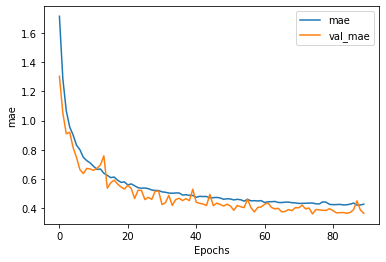

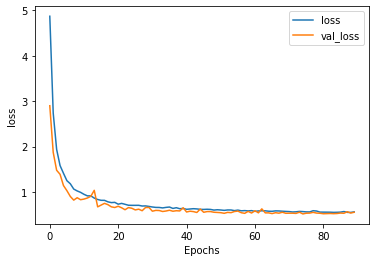

In [46]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [47]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 5s 1ms/step - loss: 0.5714 - mae: 0.3773
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 57.14%
mae: 37.73%


# LSTM 

In [48]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
     
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         512000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 520       
Total params: 792,136
Trainable params: 792,136
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 7s 274ms/step - loss: 13.7060 - mae: 3.0652 - val_loss: 4.3529 - val_mae: 1.7267
Epoch 2/100
21/21 [==============================] - 5s 247ms/step - loss: 4.9281 - mae: 1.7976 - val_loss: 3.4186 - val_mae: 1.5014
Epoch 3/100
21/21 [==============================] - 5s 247ms/step - loss: 3.2722 - mae: 1.3693 - val_loss: 1.8174 - val_mae: 0.9507
Epoch 4/100
21/21 [==============================] - 5s 231ms/step - loss: 1.9492 - mae: 1.0064 - val_loss: 1.2378 - val_mae: 0.7173
Epoch 5/100
21/21 [==============================] - 5s 249ms/step - loss: 1.5864 - mae: 0.8675 - val_loss: 1.0223 - val_mae: 0.6023
Epoch 6/100
21/21 [==============================] - 5s 231ms/step - loss: 1.4002 - mae: 0.7915 - val_loss: 0.9144 - val_mae: 0.5356
Epoch 7/100
21/21 [==============================] - 5s 248ms/step - loss: 1.2933 - mae: 0.7457 - val_loss: 0.8499 - val_mae: 0.4891
Epoch 8/100
21/21 [==============================] - 5s 231ms/step -

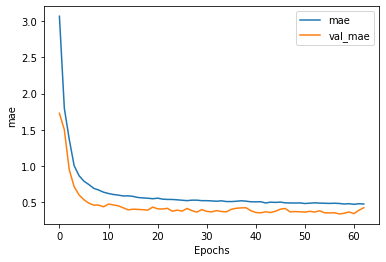

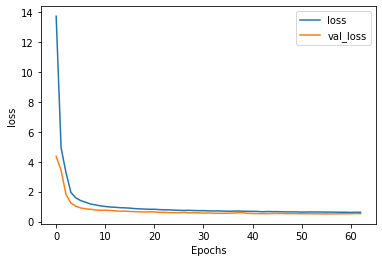

In [50]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [51]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 10s 3ms/step - loss: 0.5402 - mae: 0.4311
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 54.02%
mae: 43.11%


In [52]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test.flatten(order='F')[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 2, 3, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.96      0.67      0.79      3691
         2.0       0.59      0.54      0.57      3921
         3.0       0.59      0.73      0.65      3952
         4.0       0.71      0.81      0.76      4161
         5.0       0.77      0.81      0.79      3786
         6.0       0.88      0.81      0.84      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.75     26880
   macro avg       0.77      0.76      0.76     26880
weighted avg       0.77      0.75      0.76     26880



# Ensemble

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Decison tree classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.89      0.86       482
         3.0       0.73      0.72      0.73       510
         4.0       0.66      0.65      0.66       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  0 429  51   1   0   1   0]
 [  0  19 366 120   2   3   0]
 [  0   1  33 335 147   1   0]
 [  4   3  18  27 303 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  27  21  11   9   6 368]]
Accuracy Score : 0.768452380952381
Precision Score : 0.7673962257076504
Recall Score : 0.768452380952381
F1 Score : 0.767715049

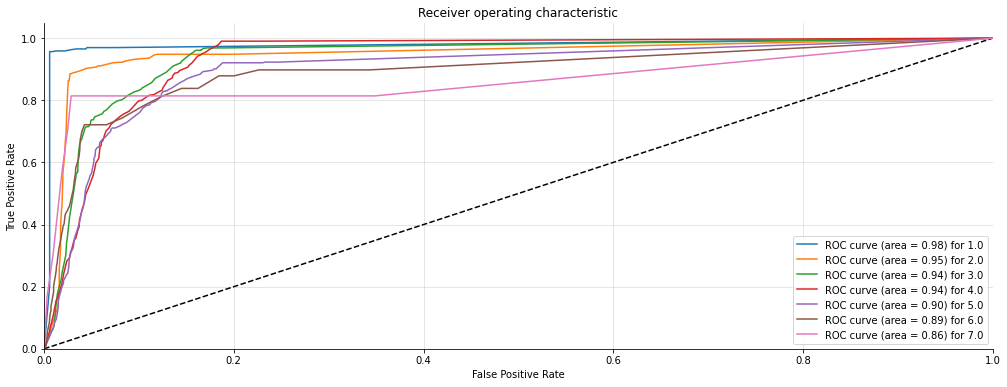

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.83      0.89      0.86       485
         3.0       0.73      0.72      0.73       501
         4.0       0.67      0.66      0.67       515
         5.0       0.70      0.71      0.71       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 430  51   0   1   3   0]
 [  0  18 363 119   1   0   0]
 [  0   2  44 342 125   2   0]
 [  3  13  17  29 328  70   0]
 [  5  18  15  13   6 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8026785714285715
Precision Score : 0.8025908373657157
Recall Score : 0.8026785714285715
F1 Score : 0.8024137417962

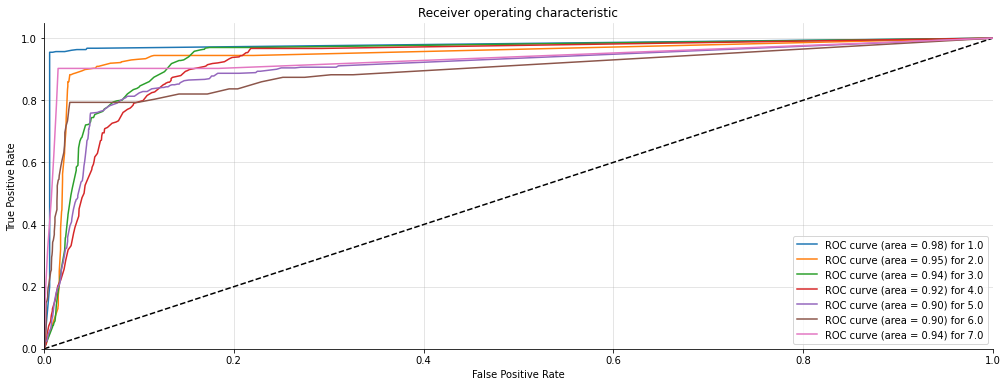

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.89      0.86       482
         3.0       0.72      0.72      0.72       506
         4.0       0.67      0.63      0.65       526
         5.0       0.65      0.66      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  0 430  51   1   0   0   0]
 [  0  18 366 118   1   3   0]
 [  0   2  45 334 145   0   0]
 [  2   4   7  26 302 117   0]
 [  6  18  20  13   6 335  77]
 [  9  28  16  10   8   6 374]]
Accuracy Score : 0.76875
Precision Score : 0.767481652140726
Recall Score : 0.76875
F1 Score : 0.7678690730302401
(3360, 7) (336

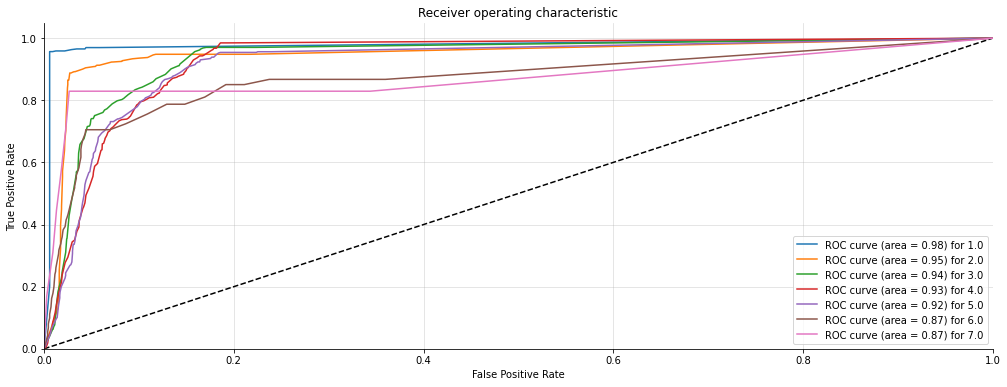

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.83      0.88      0.85       488
         3.0       0.73      0.72      0.72       506
         4.0       0.66      0.65      0.65       516
         5.0       0.66      0.67      0.66       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 430  52   2   1   3   0]
 [  0  19 365 121   0   1   0]
 [  0   0  35 334 145   2   0]
 [  2   2   9  26 304 113   0]
 [  2  15  17   9   3 339  86]
 [ 13  34  23  14   9   4 365]]
Accuracy Score : 0.7675595238095239
Precision Score : 0.7669772935963464
Recall Score : 0.7675595238095239
F1 Score : 0.7671085432202

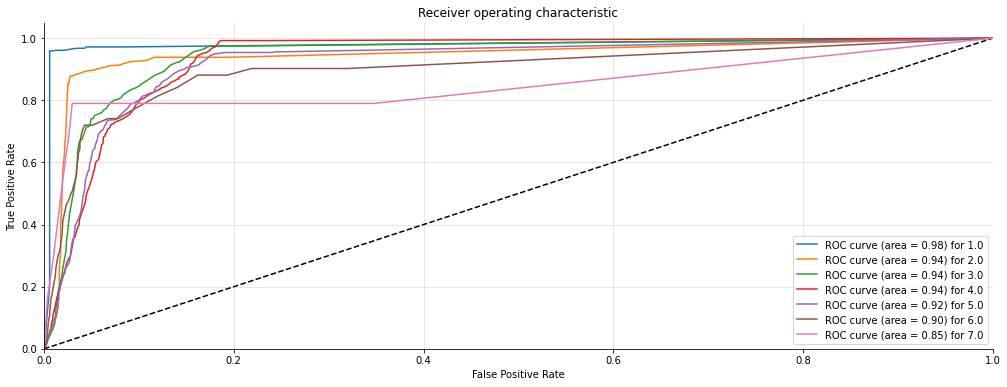

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.86      0.89      0.87       491
         3.0       0.82      0.80      0.81       487
         4.0       0.86      0.86      0.86       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 435  45   2   1   3   0]
 [  7  32 388  58   2   0   0]
 [  3  15  22 445  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9074404761904762
Precision Score : 0.9073888812344942
Recall Score : 0.9074404761904762
F1 Score : 0.90734751631951

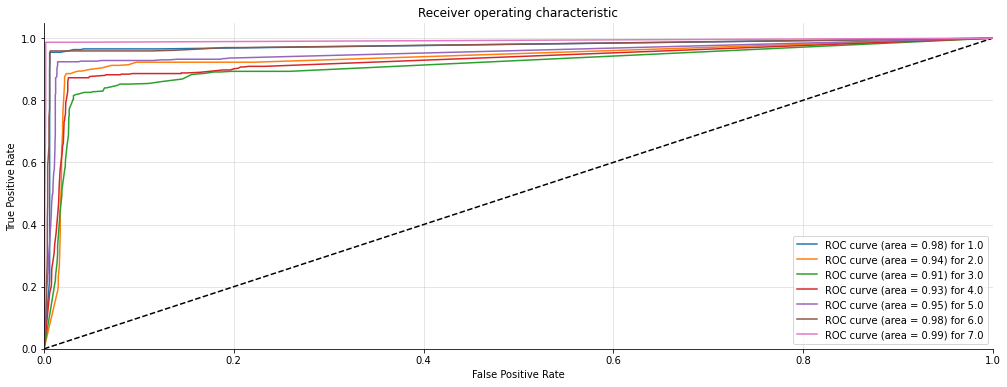

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       495
         3.0       0.81      0.78      0.79       490
         4.0       0.83      0.83      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 432  50   2   2   4   0]
 [  7  33 380  69   0   1   0]
 [  3  17  22 430  47   0   0]
 [  1   7  12  14 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8961309523809524
Precision Score : 0.8958536548746232
Recall Score : 0.8961309523809524
F1 Score : 0.89

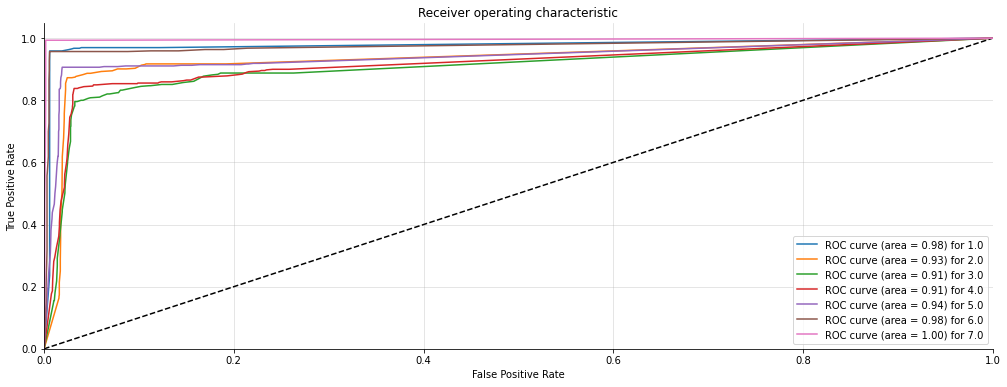

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.97      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  10 451  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9720238095238095
Precision Score : 0.9720332436992882
Recall Score : 0.9720238095238095
F1 Score : 0.9720133

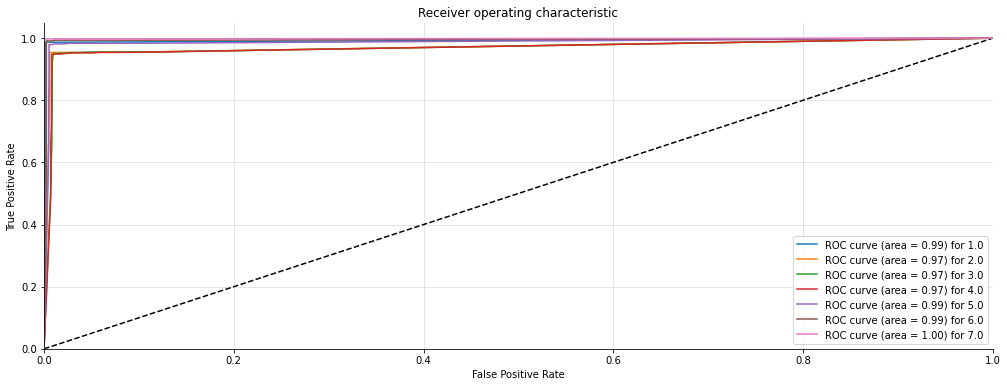

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


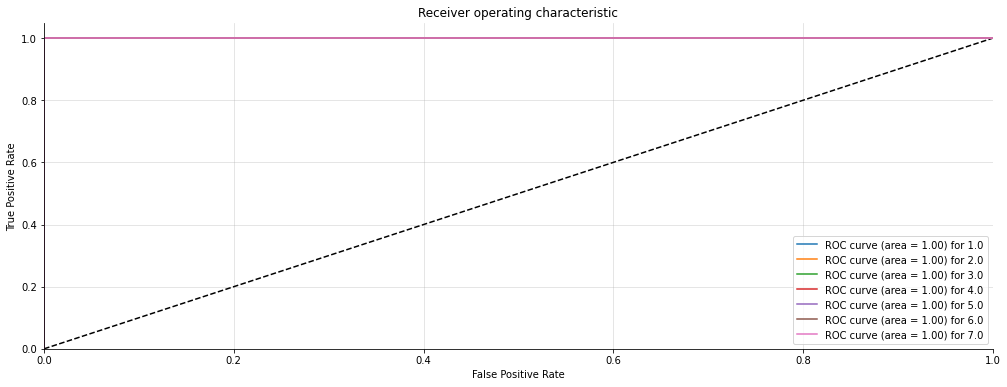

In [69]:
acc=[]
pre=[]
recal=[]
f1=[]
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def DTC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  DTC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [70]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.8603794642857143
average Precision :0.8599652235773556
average Recall :0.8603794642857143
average F1 -score :0.8600466371495117


# Random forest classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.89      0.85       482
         3.0       0.74      0.72      0.73       510
         4.0       0.67      0.65      0.66       517
         5.0       0.65      0.66      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  0 427  51   1   2   1   0]
 [  0  19 365 121   2   3   0]
 [  0   1  30 337 148   1   0]
 [  4   3  18  24 306 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  27  21  11   9   6 368]]
Accuracy Score : 0.7690476190476191
Precision Score : 0.7682442090802074
Recall Score : 0.7690476190476191
F1 Score : 0.7684379

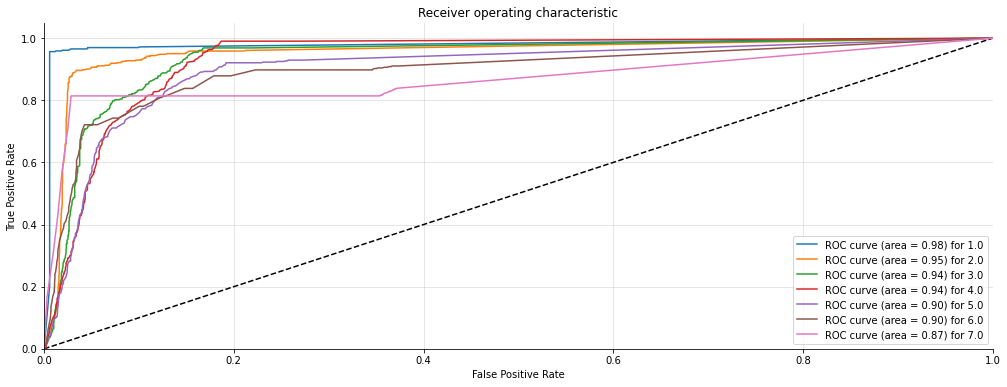

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.83      0.89      0.86       485
         3.0       0.74      0.72      0.73       501
         4.0       0.68      0.67      0.67       515
         5.0       0.70      0.72      0.71       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 430  51   0   1   3   0]
 [  0  18 362 120   1   0   0]
 [  0   2  41 343 127   2   0]
 [  3  13  17  26 331  70   0]
 [  5  18  15  13   6 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8035714285714286
Precision Score : 0.8035312638142688
Recall Score : 0.8035714285714286
F1 Score : 0.8033129469926

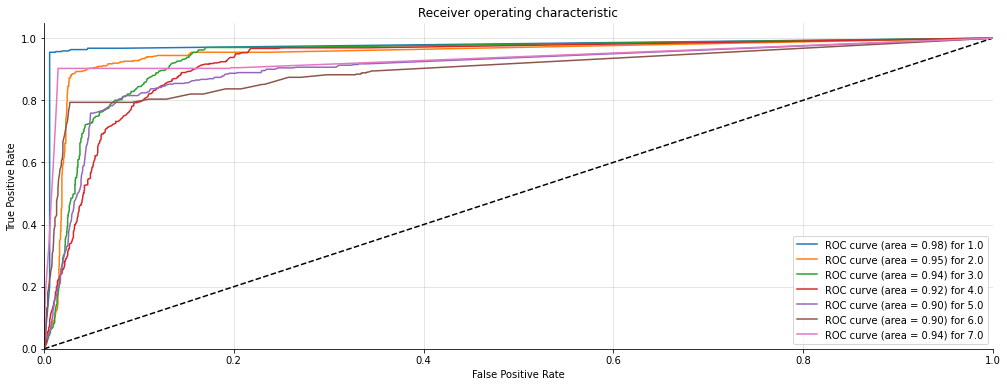

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.89      0.86       482
         3.0       0.73      0.72      0.72       506
         4.0       0.67      0.63      0.65       526
         5.0       0.65      0.67      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  0 428  51   1   2   0   0]
 [  0  18 365 119   1   3   0]
 [  0   2  42 334 148   0   0]
 [  2   4   7  20 308 117   0]
 [  6  18  20  13   6 335  77]
 [  9  28  16  10   8   6 374]]
Accuracy Score : 0.7696428571428572
Precision Score : 0.7686620973794634
Recall Score : 0.7696428571428572
F1 Score : 0.76887223

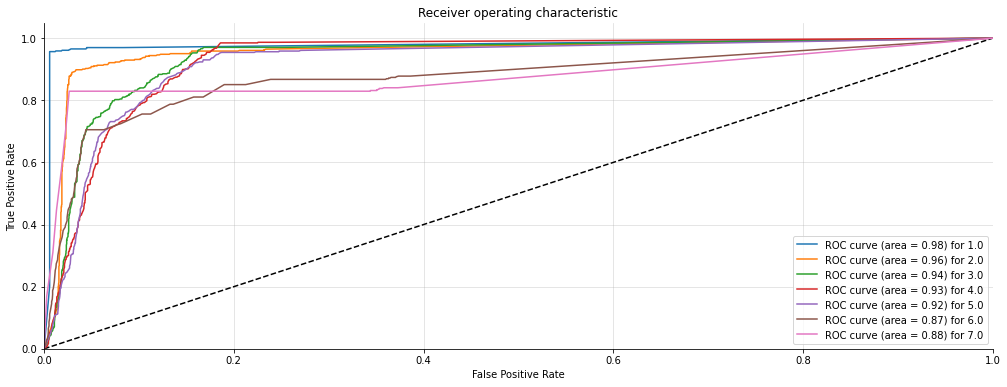

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.83      0.88      0.85       488
         3.0       0.73      0.72      0.73       506
         4.0       0.67      0.65      0.66       516
         5.0       0.66      0.68      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 428  52   2   3   3   0]
 [  0  19 364 122   0   1   0]
 [  0   0  32 334 148   2   0]
 [  2   2   9  20 310 113   0]
 [  2  15  17   9   3 339  86]
 [ 13  34  23  14   9   4 365]]
Accuracy Score : 0.768452380952381
Precision Score : 0.7681173882016233
Recall Score : 0.768452380952381
F1 Score : 0.768094641756278

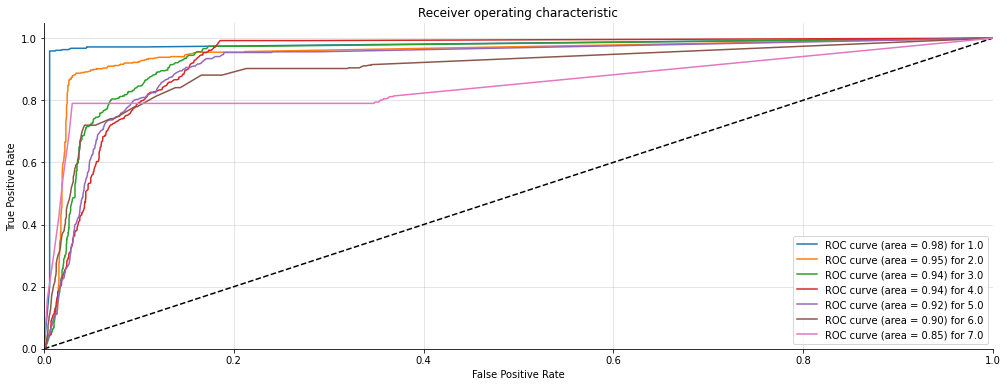

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.86      0.88      0.87       491
         3.0       0.82      0.80      0.81       487
         4.0       0.86      0.86      0.86       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 431  47   4   1   3   0]
 [  7  32 388  58   2   0   0]
 [  3  15  22 445  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.90625
Precision Score : 0.90620827957393
Recall Score : 0.90625
F1 Score : 0.906184449391064
(3360, 7) (3360, 7)


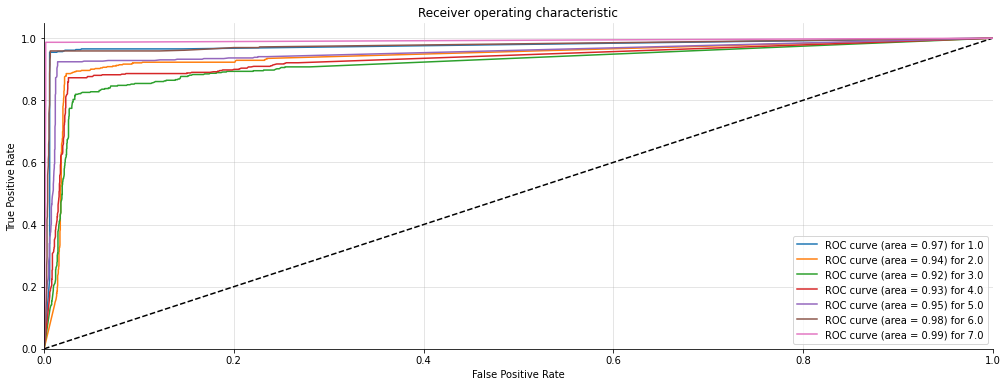

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.86      0.86       495
         3.0       0.81      0.78      0.79       490
         4.0       0.83      0.83      0.83       519
         5.0       0.88      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.89      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.89      0.89      0.89      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 428  50   4   4   4   0]
 [  7  33 380  69   0   1   0]
 [  3  17  22 430  47   0   0]
 [  1   7  12  14 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8949404761904762
Precision Score : 0.8946663609296756
Recall Score : 0.8949404761904762
F1 Score : 0.89

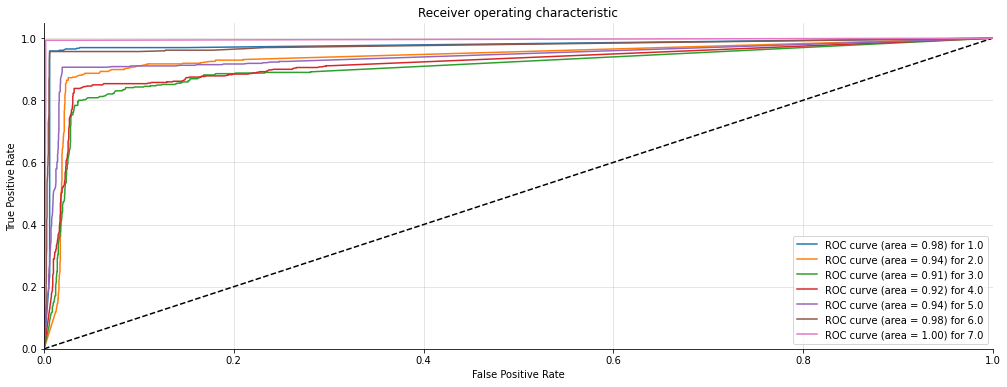

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.97      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 477  17   2   1   0   0]
 [  0  10 451  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9714285714285714
Precision Score : 0.9714579163466012
Recall Score : 0.9714285714285714
F1 Score : 0.9714211

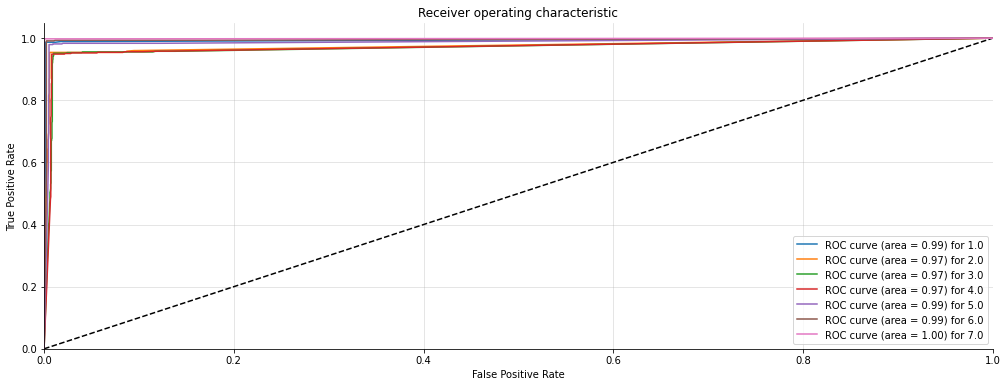

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


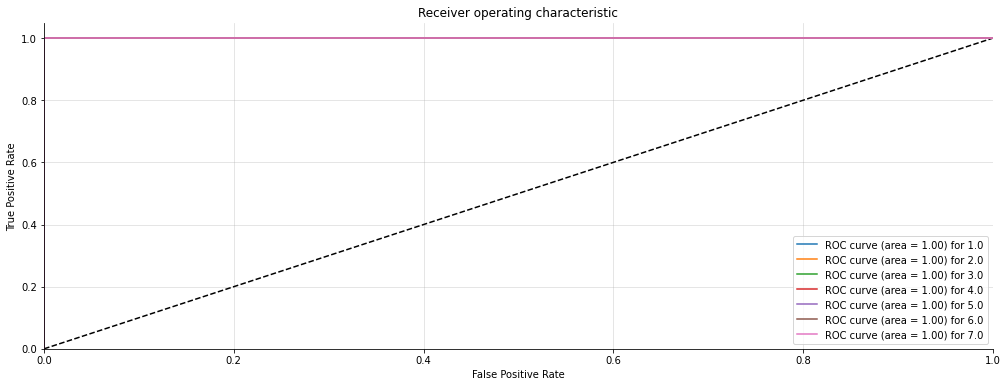

In [71]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
def RFC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  RFC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [72]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.8604166666666667
average Precision :0.8601109394157211
average Recall :0.8604166666666667
average F1 -score :0.8601308685479279


# Extra Trees Classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.89      0.86       482
         3.0       0.73      0.72      0.73       510
         4.0       0.66      0.65      0.66       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  0 429  51   1   0   1   0]
 [  0  19 366 120   2   3   0]
 [  0   1  33 335 147   1   0]
 [  4   3  18  27 303 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  27  21  11   9   6 368]]
Accuracy Score : 0.768452380952381
Precision Score : 0.7673962257076504
Recall Score : 0.768452380952381
F1 Score : 0.767715049

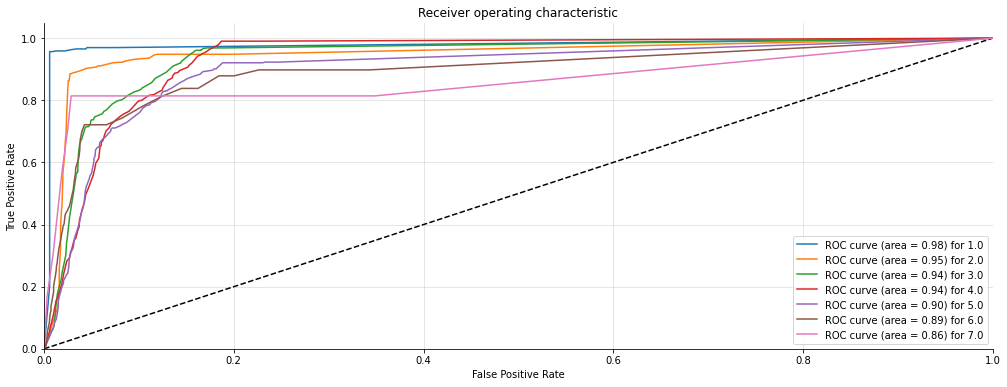

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.83      0.89      0.86       485
         3.0       0.73      0.72      0.73       501
         4.0       0.67      0.66      0.67       515
         5.0       0.70      0.71      0.71       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 430  51   0   1   3   0]
 [  0  18 363 119   1   0   0]
 [  0   2  44 342 125   2   0]
 [  3  13  17  29 328  70   0]
 [  5  18  15  13   6 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8026785714285715
Precision Score : 0.8025908373657157
Recall Score : 0.8026785714285715
F1 Score : 0.8024137417962

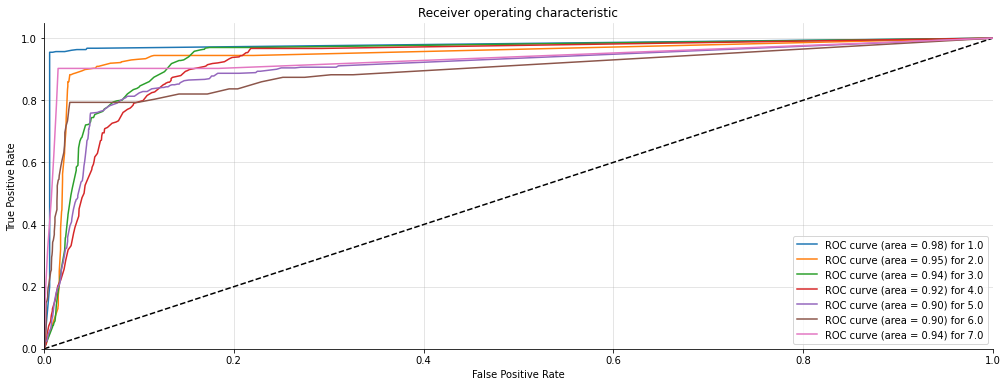

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.89      0.86       482
         3.0       0.72      0.72      0.72       506
         4.0       0.67      0.63      0.65       526
         5.0       0.65      0.66      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  0 430  51   1   0   0   0]
 [  0  18 366 118   1   3   0]
 [  0   2  45 334 145   0   0]
 [  2   4   7  26 302 117   0]
 [  6  18  20  13   6 335  77]
 [  9  28  16  10   8   6 374]]
Accuracy Score : 0.76875
Precision Score : 0.767481652140726
Recall Score : 0.76875
F1 Score : 0.7678690730302401
(3360, 7) (336

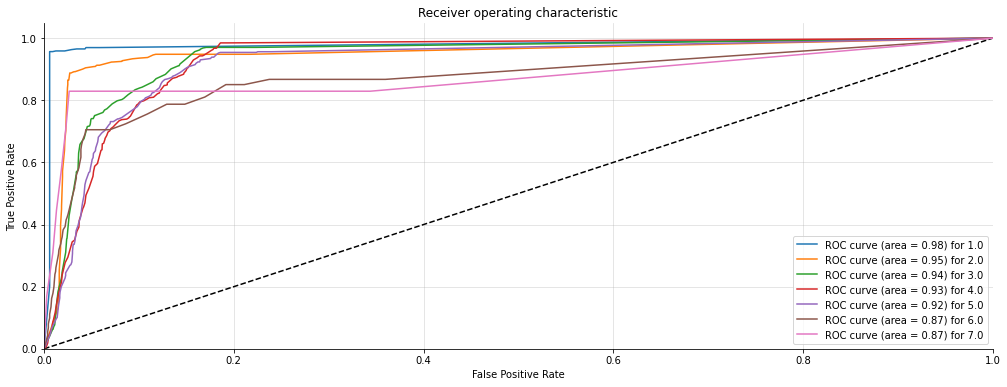

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.83      0.88      0.85       488
         3.0       0.73      0.72      0.72       506
         4.0       0.66      0.65      0.65       516
         5.0       0.66      0.67      0.66       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 430  52   2   1   3   0]
 [  0  19 365 121   0   1   0]
 [  0   0  35 334 145   2   0]
 [  2   2   9  26 304 113   0]
 [  2  15  17   9   3 339  86]
 [ 13  34  23  14   9   4 365]]
Accuracy Score : 0.7675595238095239
Precision Score : 0.7669772935963464
Recall Score : 0.7675595238095239
F1 Score : 0.7671085432202

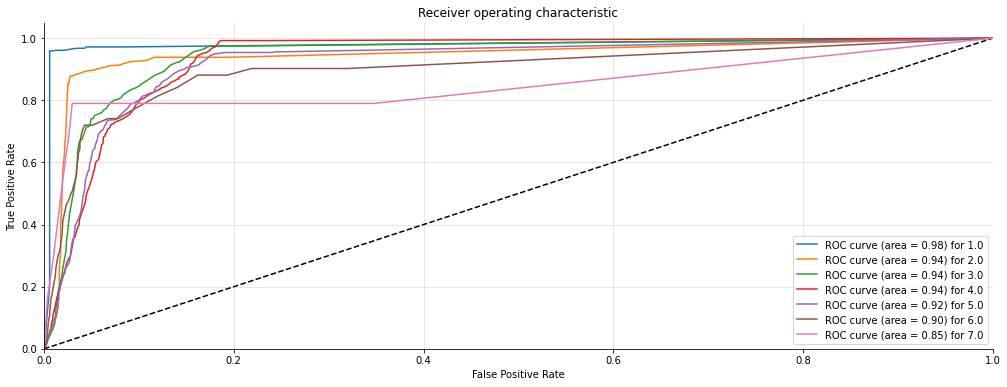

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.86      0.89      0.87       491
         3.0       0.82      0.80      0.81       487
         4.0       0.86      0.86      0.86       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 435  45   2   1   3   0]
 [  7  32 388  58   2   0   0]
 [  3  15  22 445  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9074404761904762
Precision Score : 0.9073888812344942
Recall Score : 0.9074404761904762
F1 Score : 0.90734751631951

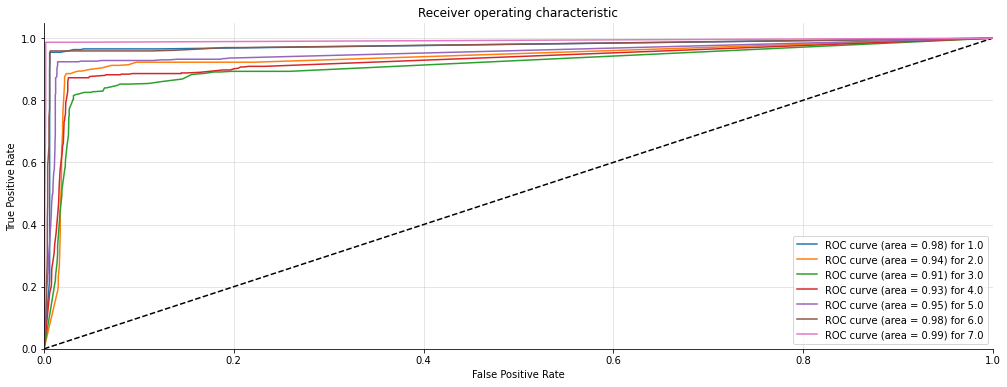

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       495
         3.0       0.81      0.78      0.79       490
         4.0       0.83      0.83      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 432  50   2   2   4   0]
 [  7  33 380  69   0   1   0]
 [  3  17  22 430  47   0   0]
 [  1   7  12  14 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8961309523809524
Precision Score : 0.8958536548746232
Recall Score : 0.8961309523809524
F1 Score : 0.89

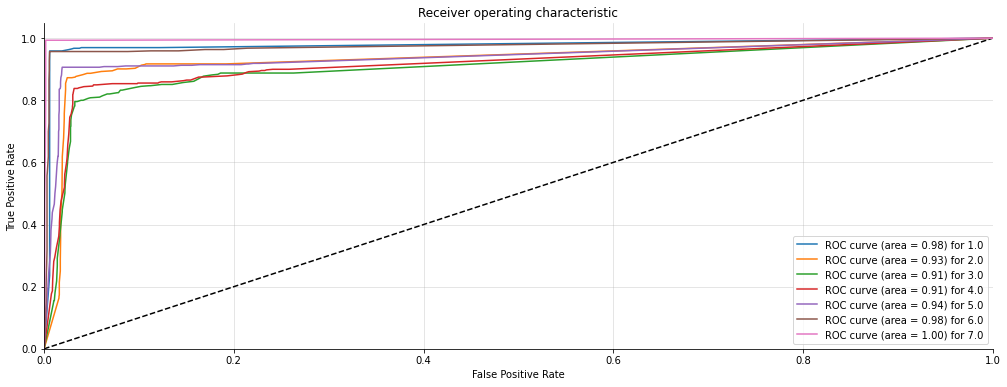

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.97      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  10 451  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9720238095238095
Precision Score : 0.9720332436992882
Recall Score : 0.9720238095238095
F1 Score : 0.9720133

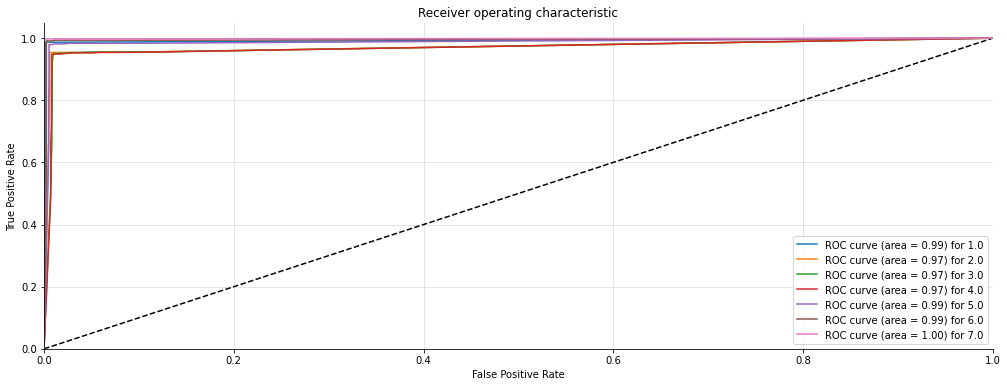

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


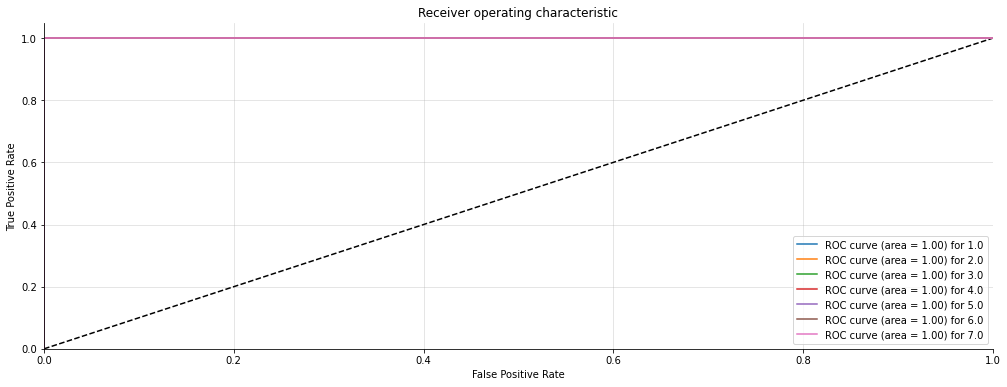

In [73]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
def ETC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = ExtraTreesClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ETC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [74]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.8603794642857143
average Precision :0.8599652235773556
average Recall :0.8603794642857143
average F1 -score :0.8600466371495117


# Adaboost 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.52      0.66      0.58       462
         2.0       0.39      0.41      0.40       482
         3.0       0.33      0.29      0.31       510
         4.0       0.38      0.35      0.36       517
         5.0       0.32      0.32      0.32       467
         6.0       0.47      0.33      0.39       470
         7.0       0.69      0.82      0.75       452

    accuracy                           0.45      3360
   macro avg       0.44      0.46      0.45      3360
weighted avg       0.44      0.45      0.44      3360

Confusion Matrix: 
 [[305  63  34  18  16  11  15]
 [ 91 200  43  71  44  27   6]
 [ 60 105 148  80  64  34  19]
 [ 32  72  91 181  98  26  17]
 [ 41  33  71  90 151  70  11]
 [ 38  28  38  26  86 157  97]
 [ 17  17  17  10  13   8 370]]
Accuracy Score : 0.45
Precision Score : 0.4399804600419463
Recall Score : 0.45
F1 Score : 0.44111261786547973
(3360, 7) (3360, 

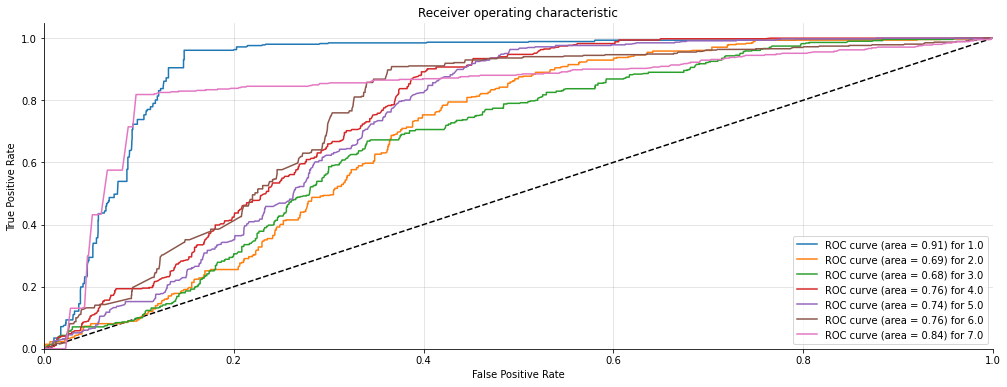

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.55      0.70      0.61       463
         2.0       0.36      0.40      0.38       485
         3.0       0.32      0.26      0.29       501
         4.0       0.37      0.35      0.36       515
         5.0       0.32      0.33      0.32       460
         6.0       0.54      0.41      0.47       484
         7.0       0.83      0.90      0.86       452

    accuracy                           0.47      3360
   macro avg       0.47      0.48      0.47      3360
weighted avg       0.46      0.47      0.46      3360

Confusion Matrix: 
 [[324  48  28  30   7  11  15]
 [ 74 194  45  61  54  42  15]
 [ 52 110 128  84  76  42   9]
 [ 27  96  82 181 110  19   0]
 [ 38  53  68  94 151  52   4]
 [ 64  31  39  34  73 200  43]
 [ 13  12   5   2   6   5 409]]
Accuracy Score : 0.47232142857142856
Precision Score : 0.4644385666190358
Recall Score : 0.47232142857142856
F1 Score : 0.46481190694

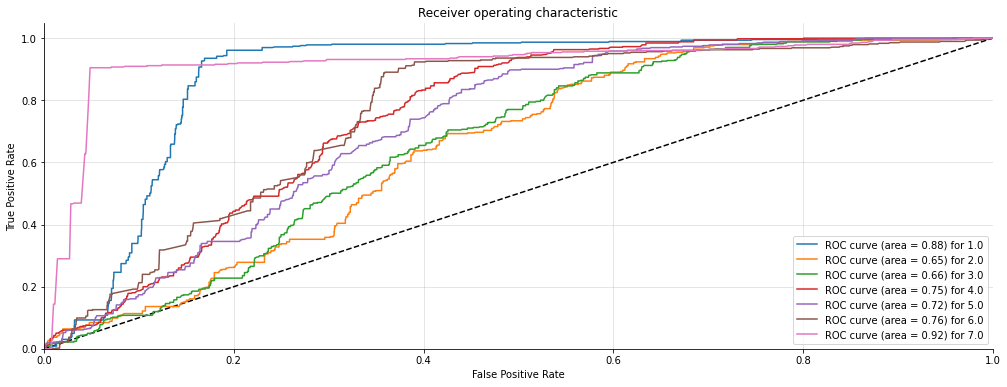

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.55      0.72      0.62       462
         2.0       0.36      0.37      0.36       482
         3.0       0.35      0.31      0.33       506
         4.0       0.36      0.34      0.35       526
         5.0       0.31      0.30      0.31       458
         6.0       0.36      0.38      0.37       475
         7.0       0.66      0.53      0.59       451

    accuracy                           0.42      3360
   macro avg       0.42      0.42      0.42      3360
weighted avg       0.42      0.42      0.42      3360

Confusion Matrix: 
 [[332  40  27  22  19  19   3]
 [ 84 178  45  78  44  35  18]
 [ 57  88 158  86  53  41  23]
 [ 31  81  98 177 108  23   8]
 [ 38  44  67  93 138  71   7]
 [ 46  49  43  23  70 182  62]
 [ 16  16  18   8  12 141 240]]
Accuracy Score : 0.4181547619047619
Precision Score : 0.4179924786683194
Recall Score : 0.4181547619047619
F1 Score : 0.41523019

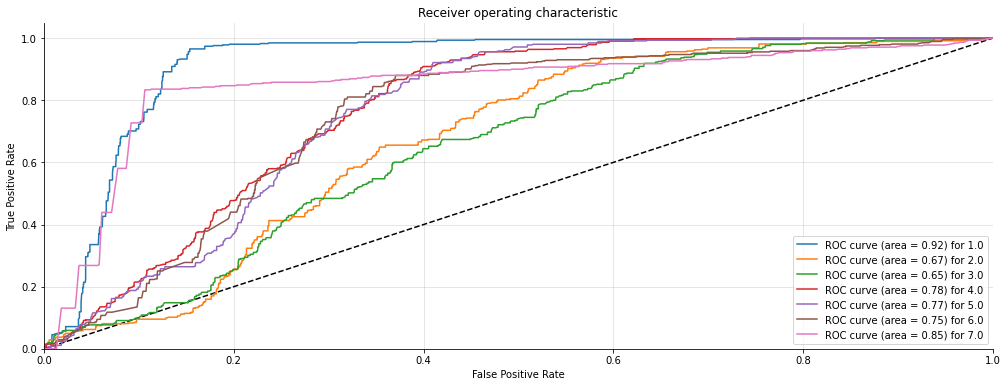

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.50      0.65      0.57       461
         2.0       0.39      0.42      0.40       488
         3.0       0.37      0.35      0.36       506
         4.0       0.38      0.31      0.34       516
         5.0       0.27      0.29      0.28       456
         6.0       0.45      0.38      0.41       471
         7.0       0.67      0.63      0.65       462

    accuracy                           0.43      3360
   macro avg       0.43      0.43      0.43      3360
weighted avg       0.43      0.43      0.43      3360

Confusion Matrix: 
 [[300  68  36  21  12  11  13]
 [ 91 205  51  59  35  37  10]
 [ 57  95 176  68  52  47  11]
 [ 49  73 102 161 103  21   7]
 [ 39  38  56  84 133 100   6]
 [ 37  26  42  18  75 179  94]
 [ 22  26  13  15  88   7 291]]
Accuracy Score : 0.43005952380952384
Precision Score : 0.4302553837608775
Recall Score : 0.43005952380952384
F1 Score : 0.42770763365

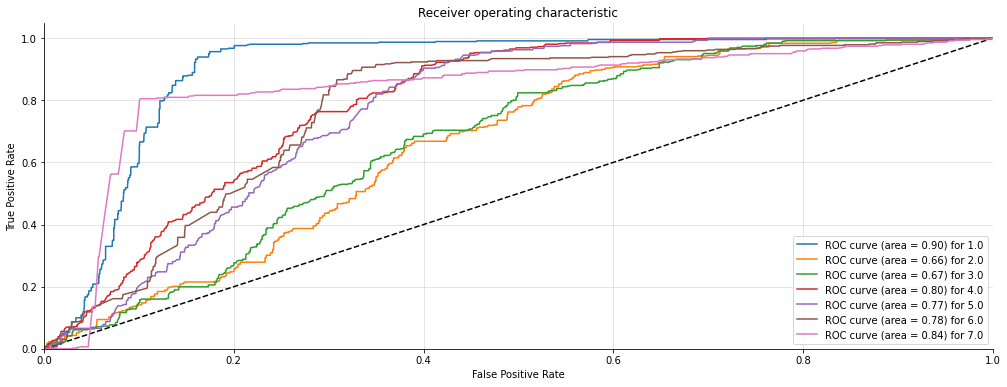

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.23      0.39      0.29       463
         2.0       0.23      0.25      0.24       491
         3.0       0.22      0.14      0.17       487
         4.0       0.26      0.21      0.23       518
         5.0       0.22      0.26      0.24       487
         6.0       0.32      0.23      0.27       462
         7.0       0.96      0.83      0.89       452

    accuracy                           0.32      3360
   macro avg       0.35      0.33      0.33      3360
weighted avg       0.34      0.32      0.33      3360

Confusion Matrix: 
 [[181  81  33  48  81  39   0]
 [114 123  58  54 110  28   4]
 [123  72  68  85 107  31   1]
 [126  94  40 110 100  42   6]
 [113 107  49  73 127  18   0]
 [136  64  59  49  44 107   3]
 [  3   0   2   1   0  72 374]]
Accuracy Score : 0.3244047619047619
Precision Score : 0.3425081444514709
Recall Score : 0.3244047619047619
F1 Score : 0.32685676372314

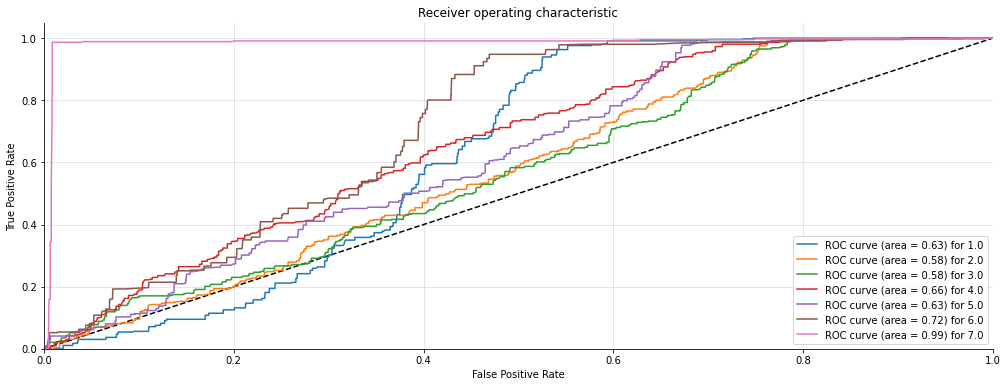

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.24      0.29      0.26       461
         2.0       0.20      0.15      0.17       495
         3.0       0.18      0.18      0.18       490
         4.0       0.20      0.17      0.18       519
         5.0       0.24      0.43      0.31       481
         6.0       0.35      0.22      0.27       465
         7.0       0.96      0.83      0.89       449

    accuracy                           0.32      3360
   macro avg       0.34      0.32      0.32      3360
weighted avg       0.33      0.32      0.32      3360

Confusion Matrix: 
 [[134  45  60  64 107  51   0]
 [107  74  61  90 136  26   1]
 [ 86  69  88  70 135  36   6]
 [ 84  77  65  86 160  43   4]
 [ 59  64  55  64 206  33   0]
 [ 91  36  83  48 101 103   3]
 [  0   0  74   0   1   0 374]]
Accuracy Score : 0.3169642857142857
Precision Score : 0.33300838447744663
Recall Score : 0.3169642857142857
F1 Score : 0.3

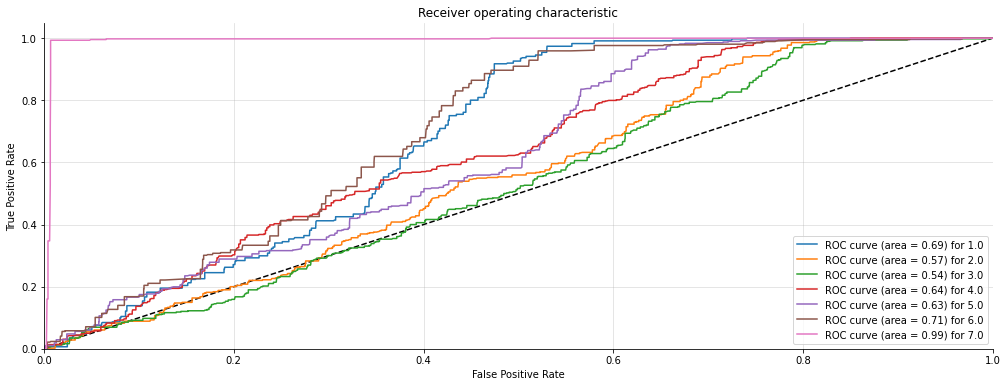

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.22      0.39      0.29       460
         2.0       0.21      0.21      0.21       502
         3.0       0.24      0.16      0.19       474
         4.0       0.22      0.22      0.22       527
         5.0       0.16      0.16      0.16       486
         6.0       0.25      0.20      0.22       459
         7.0       0.95      0.81      0.88       452

    accuracy                           0.30      3360
   macro avg       0.32      0.31      0.31      3360
weighted avg       0.32      0.30      0.30      3360

Confusion Matrix: 
 [[181  93  44  62  60  20   0]
 [119 104  37 101 106  35   0]
 [119  48  74  95  85  48   5]
 [144  83  48 115  96  34   7]
 [134  80  48  90  79  55   0]
 [110  86  57  52  56  92   6]
 [  1   0   0   0   0  84 367]]
Accuracy Score : 0.3011904761904762
Precision Score : 0.3171323296555497
Recall Score : 0.3011904761904762
F1 Score : 0.3035775

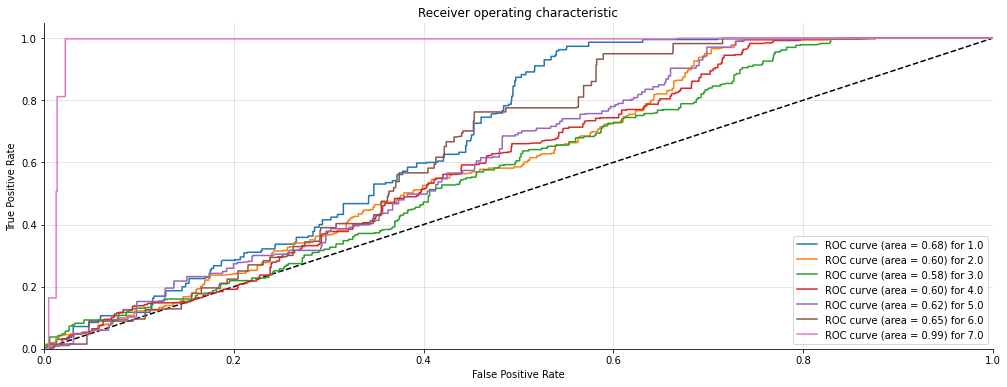

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.22      0.18      0.20       459
         2.0       0.22      0.17      0.19       496
         3.0       0.21      0.18      0.19       478
         4.0       0.09      0.11      0.10       523
         5.0       0.12      0.08      0.09       491
         6.0       0.18      0.42      0.25       462
         7.0       0.97      0.49      0.65       451

    accuracy                           0.23      3360
   macro avg       0.29      0.23      0.24      3360
weighted avg       0.28      0.23      0.23      3360

Confusion Matrix: 
 [[ 84  59  50  88  51 127   0]
 [ 56  83  48  67  68 174   0]
 [ 63  74  85  70  29 157   0]
 [ 79  54  86  55  55 187   7]
 [ 58  51  65  58  38 221   0]
 [ 45  48  69  28  80 192   0]
 [  0   0   0 229   0   0 222]]
Accuracy Score : 0.22589285714285715
Precision Score : 0.27977828595423393
Recall Score : 0.22589285714285715
F1 Score : 0.23434316

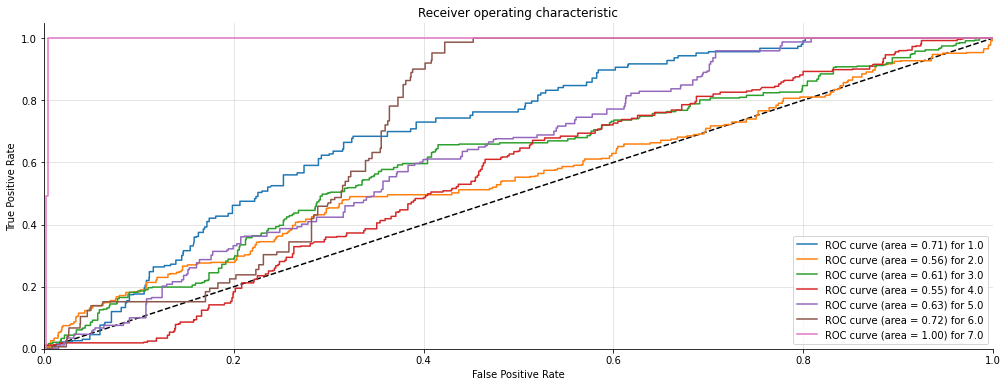

In [75]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
def ADB(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = AdaBoostClassifier(n_estimators=500)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ADB(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [76]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.3673735119047619
average Precision :0.37813675420361004
average Recall :0.3673735119047619
average F1 -score :0.36637887190308255


# Gradient boosting 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.53      0.84      0.65       462
         2.0       0.43      0.41      0.42       482
         3.0       0.37      0.26      0.31       510
         4.0       0.42      0.34      0.37       517
         5.0       0.37      0.33      0.35       467
         6.0       0.57      0.61      0.59       470
         7.0       0.77      0.82      0.79       452

    accuracy                           0.51      3360
   macro avg       0.49      0.51      0.50      3360
weighted avg       0.49      0.51      0.49      3360

Confusion Matrix: 
 [[387  29  10   9  12  14   1]
 [104 198  46  65  29  27  13]
 [ 82  89 133  93  58  42  13]
 [ 58  65  79 176 123  16   0]
 [ 54  41  55  59 153 105   0]
 [ 24  18  21  12  25 286  84]
 [ 19  18  13  10  13   9 370]]
Accuracy Score : 0.5068452380952381
Precision Score : 0.49067005390027907
Recall Score : 0.5068452380952381
F1 Score : 0.491590

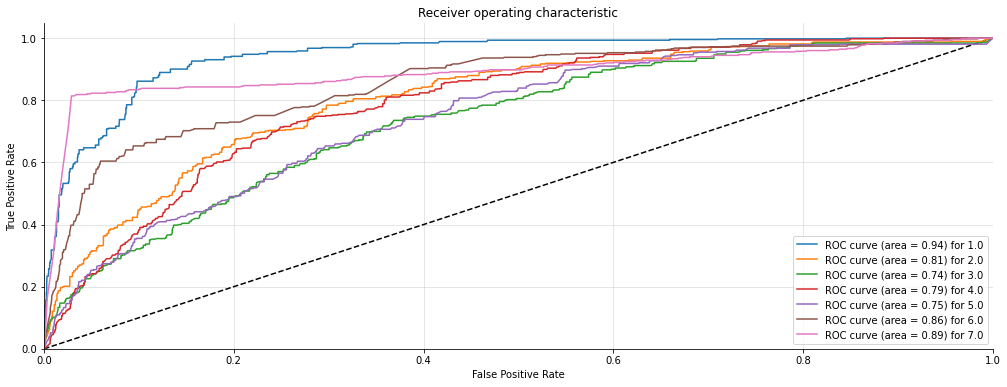

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.46      0.77      0.58       463
         2.0       0.30      0.28      0.29       485
         3.0       0.27      0.13      0.18       501
         4.0       0.28      0.27      0.27       515
         5.0       0.25      0.28      0.26       460
         6.0       0.24      0.30      0.27       484
         7.0       0.74      0.45      0.56       452

    accuracy                           0.35      3360
   macro avg       0.36      0.35      0.34      3360
weighted avg       0.36      0.35      0.34      3360

Confusion Matrix: 
 [[358  19  13  21  24  22   6]
 [110 134  58  63  56  54  10]
 [ 88  80  66 104  90  59  14]
 [ 77  91  39 137 115  48   8]
 [ 71  65  34  95 127  66   2]
 [ 64  48  25  74  93 147  33]
 [ 13  10   6   3   4 213 203]]
Accuracy Score : 0.3488095238095238
Precision Score : 0.3573930214122528
Recall Score : 0.3488095238095238
F1 Score : 0.3384987511720

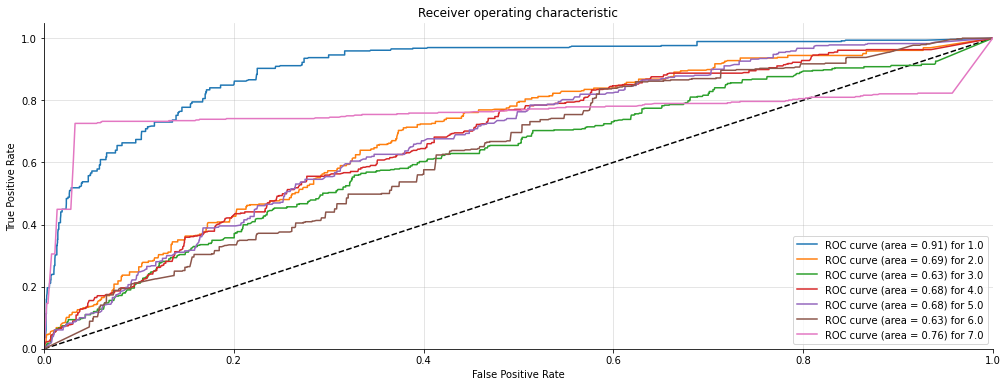

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.51      0.81      0.63       462
         2.0       0.41      0.33      0.37       482
         3.0       0.45      0.34      0.39       506
         4.0       0.41      0.36      0.38       526
         5.0       0.35      0.35      0.35       458
         6.0       0.58      0.56      0.57       475
         7.0       0.79      0.84      0.81       451

    accuracy                           0.51      3360
   macro avg       0.50      0.51      0.50      3360
weighted avg       0.50      0.51      0.49      3360

Confusion Matrix: 
 [[376  33   6  12  32   1   2]
 [107 158  63  71  47  23  13]
 [ 80  79 174  76  47  41   9]
 [ 57  54  71 190 132  22   0]
 [ 56  26  37  83 159  97   0]
 [ 45  18  25  19  24 266  78]
 [ 18  15  10  11  12   8 377]]
Accuracy Score : 0.5059523809523809
Precision Score : 0.4969966345663711
Recall Score : 0.5059523809523809
F1 Score : 0.49447821

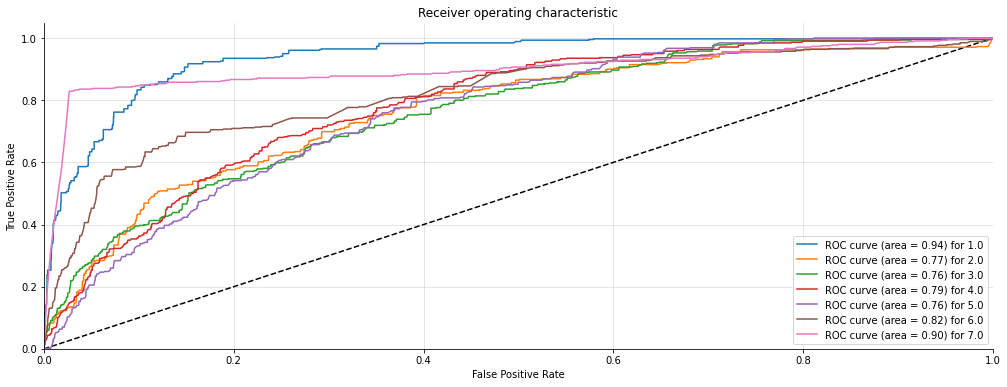

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.53      0.86      0.66       461
         2.0       0.46      0.43      0.45       488
         3.0       0.47      0.31      0.38       506
         4.0       0.43      0.38      0.40       516
         5.0       0.34      0.30      0.32       456
         6.0       0.57      0.61      0.59       471
         7.0       0.80      0.79      0.79       462

    accuracy                           0.52      3360
   macro avg       0.51      0.53      0.51      3360
weighted avg       0.51      0.52      0.51      3360

Confusion Matrix: 
 [[396  33   9   8   9   5   1]
 [ 89 211  54  55  45  30   4]
 [ 79  87 159  78  54  46   3]
 [ 64  45  65 194 122  26   0]
 [ 59  34  30  91 136 106   0]
 [ 34  23   9  15  16 288  86]
 [ 26  27  15  10  14   5 365]]
Accuracy Score : 0.5205357142857143
Precision Score : 0.511367656516905
Recall Score : 0.5205357142857143
F1 Score : 0.50772040164795

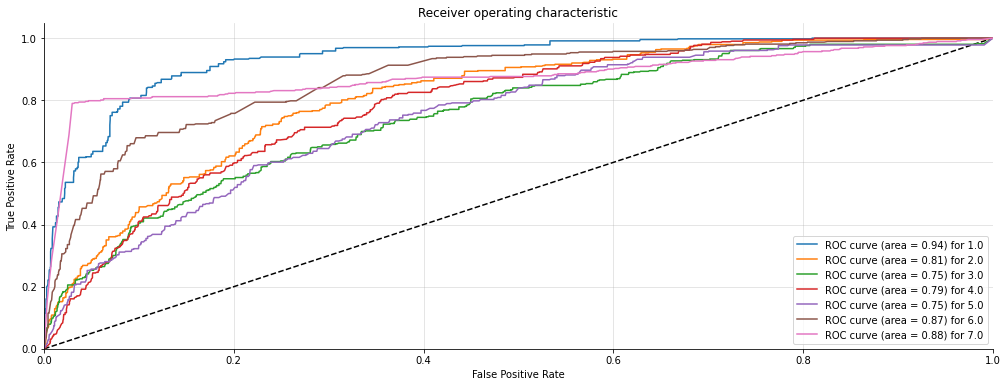

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.49      0.76      0.60       463
         2.0       0.35      0.26      0.30       491
         3.0       0.29      0.23      0.26       487
         4.0       0.38      0.25      0.30       518
         5.0       0.25      0.21      0.23       487
         6.0       0.41      0.51      0.46       462
         7.0       0.79      0.99      0.88       452

    accuracy                           0.45      3360
   macro avg       0.42      0.46      0.43      3360
weighted avg       0.42      0.45      0.42      3360

Confusion Matrix: 
 [[353  16  17  12  16  36  13]
 [103 128  60  54  83  39  24]
 [ 88  73 111  46  74  66  29]
 [ 57  55  81 130  92  88  15]
 [ 56  68  60  71 104 106  22]
 [ 58  31  53  26  45 236  13]
 [  2   0   0   1   2   1 446]]
Accuracy Score : 0.4488095238095238
Precision Score : 0.4190444401872077
Recall Score : 0.4488095238095238
F1 Score : 0.42407860288251

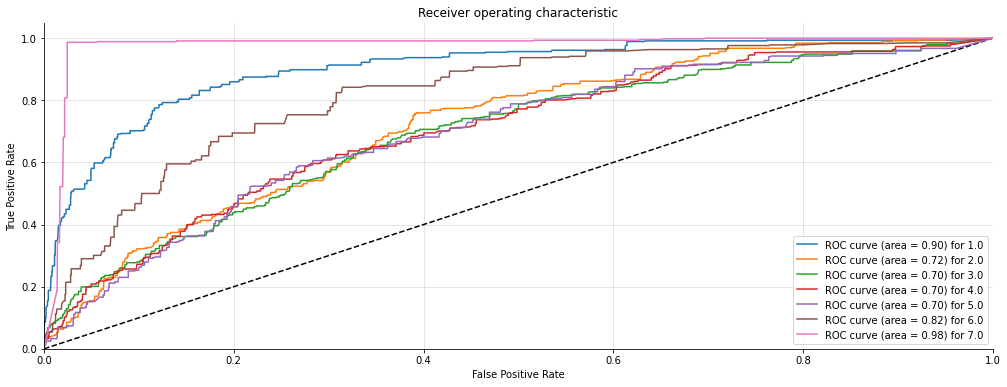

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.43      0.71      0.53       461
         2.0       0.29      0.20      0.23       495
         3.0       0.26      0.22      0.24       490
         4.0       0.32      0.24      0.28       519
         5.0       0.38      0.45      0.41       481
         6.0       0.39      0.35      0.37       465
         7.0       0.98      0.99      0.99       449

    accuracy                           0.44      3360
   macro avg       0.43      0.45      0.44      3360
weighted avg       0.43      0.44      0.43      3360

Confusion Matrix: 
 [[326  25  21  24  31  34   0]
 [114  97  86  62  79  57   0]
 [ 89  72 110  59 102  55   3]
 [ 68  68  83 126 102  70   2]
 [ 74  33  54  62 216  42   0]
 [ 91  37  68  61  39 164   5]
 [  0   0   0   0   2   1 446]]
Accuracy Score : 0.4419642857142857
Precision Score : 0.4276608976482179
Recall Score : 0.4419642857142857
F1 Score : 0.42

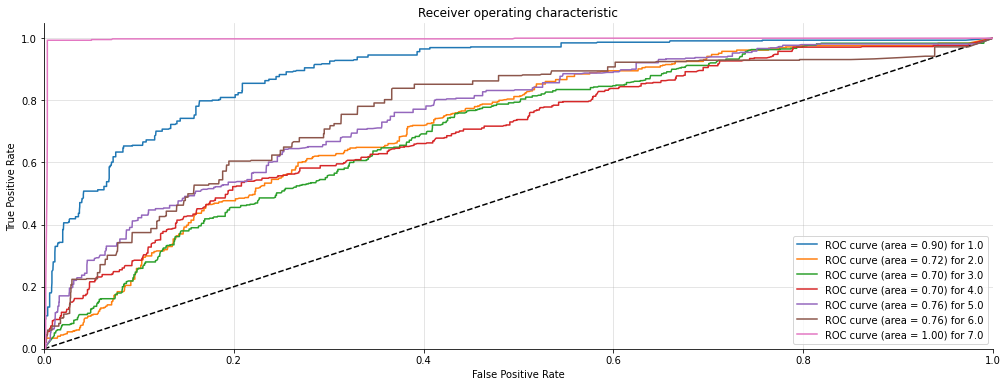

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.60      0.82      0.69       460
         2.0       0.48      0.39      0.43       502
         3.0       0.43      0.29      0.35       474
         4.0       0.59      0.51      0.54       527
         5.0       0.44      0.45      0.45       486
         6.0       0.75      0.97      0.85       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.62      3360
   macro avg       0.61      0.63      0.62      3360
weighted avg       0.61      0.62      0.61      3360

Confusion Matrix: 
 [[377  22  15   8  25  13   0]
 [ 93 198  58  50  80  23   0]
 [ 60  86 139  59  97  33   0]
 [ 51  51  45 267  74  39   0]
 [ 41  48  70  71 221  35   0]
 [  8   6   0   0   2 443   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.6238095238095238
Precision Score : 0.6075859735108148
Recall Score : 0.6238095238095238
F1 Score : 0.6087484

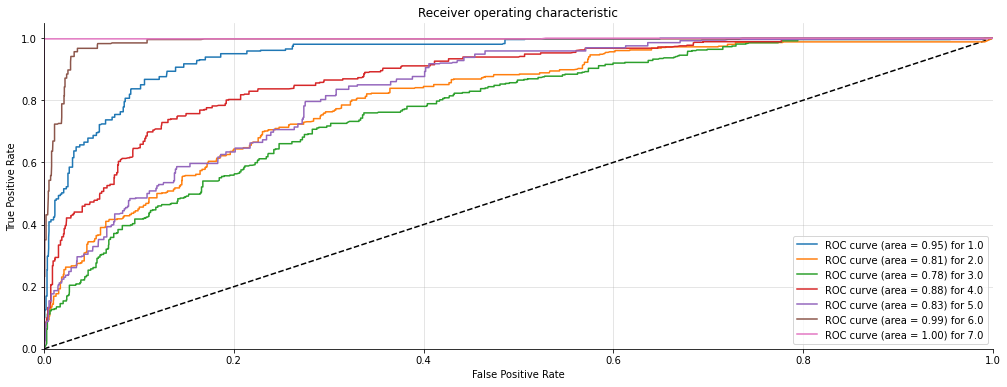

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.51      0.84      0.63       459
         2.0       0.27      0.18      0.21       496
         3.0       0.39      0.27      0.32       478
         4.0       0.42      0.38      0.40       523
         5.0       0.41      0.43      0.42       491
         6.0       0.43      0.47      0.45       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.50      3360
   macro avg       0.49      0.51      0.49      3360
weighted avg       0.48      0.50      0.48      3360

Confusion Matrix: 
 [[386   6  10  28  11  18   0]
 [111  87  77  89  77  55   0]
 [ 59  67 129  68  81  74   0]
 [ 71  75  42 201  84  50   0]
 [ 71  42  28  49 209  92   0]
 [ 60  46  47  44  46 219   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.5005952380952381
Precision Score : 0.48337682829592216
Recall Score : 0.5005952380952381
F1 Score : 0.4831817832

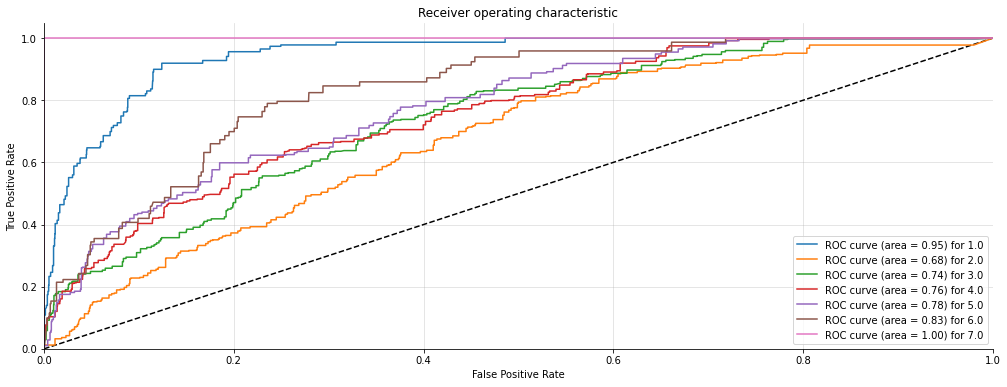

In [77]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
def GBC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  GBC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [78]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.4871651785714286
average Precision :0.47426193825474633
average Recall :0.4871651785714286
average F1 -score :0.47192861412702536


# Bagging classfier

In [79]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       462
         2.0       0.82      0.87      0.84       482
         3.0       0.73      0.71      0.72       510
         4.0       0.66      0.65      0.66       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.72       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.76      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  3 419  52   2   1   5   0]
 [  0  23 360 122   2   3   0]
 [  0   1  36 335 144   1   0]
 [  4   3  18  25 305 112   0]
 [  3  19  10  10   6 339  83]
 [ 11  26  20  11  10   6 368]]
Accuracy Score : 0.7642857142857142
Precision Score : 0.7632328286098918
Recall Score : 0.7642857142857142
F1 Score : 0.7636187

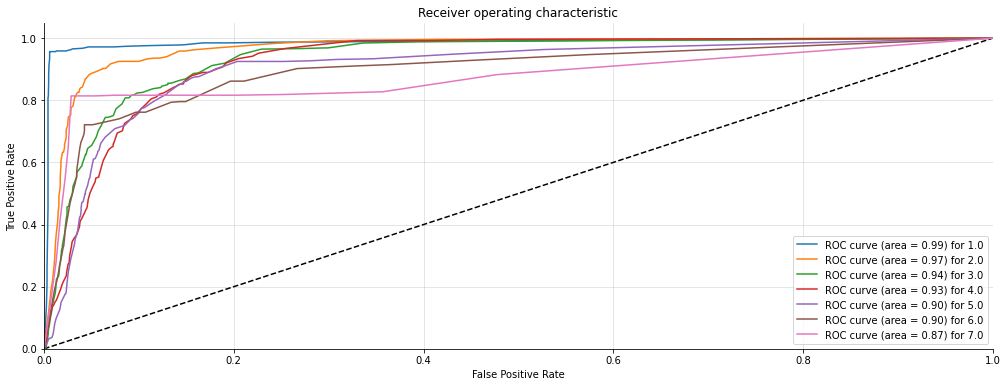

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.82      0.85      0.83       485
         3.0       0.71      0.71      0.71       501
         4.0       0.66      0.63      0.64       515
         5.0       0.68      0.72      0.70       460
         6.0       0.82      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.79      3360
   macro avg       0.79      0.79      0.79      3360
weighted avg       0.79      0.79      0.79      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 412  50   9   8   3   0]
 [  0  18 358 116   8   1   0]
 [  0   5  56 322 126   6   0]
 [  3  13  17  28 329  70   0]
 [  5  18  16  12   6 384  43]
 [  9  18   7   3   5   2 408]]
Accuracy Score : 0.7901785714285714
Precision Score : 0.7900563180075204
Recall Score : 0.7901785714285714
F1 Score : 0.7899216054754

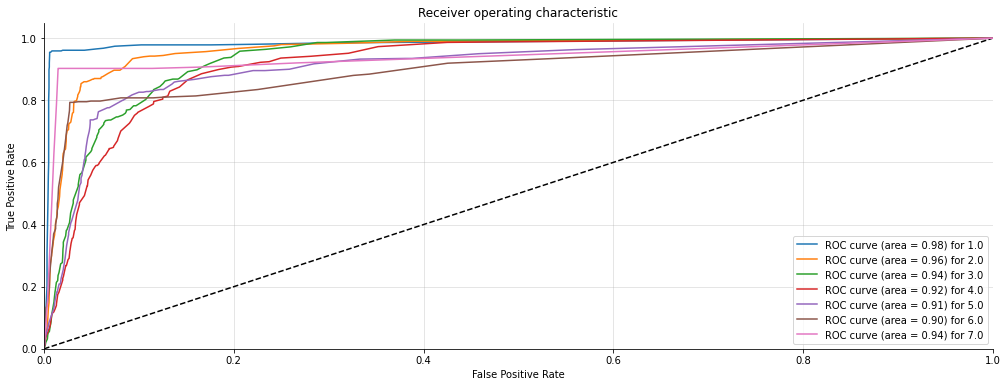

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       462
         2.0       0.83      0.87      0.84       482
         3.0       0.70      0.72      0.71       506
         4.0       0.65      0.62      0.63       526
         5.0       0.64      0.65      0.65       458
         6.0       0.72      0.69      0.70       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  4 417  58   2   1   0   0]
 [  4  17 363 114   2   4   2]
 [  0   2  58 325 138   3   0]
 [  2   5   7  35 298 111   0]
 [  6  18  20  13  15 326  77]
 [ 10  27  14  11  10   5 374]]
Accuracy Score : 0.7574404761904762
Precision Score : 0.7559745910445086
Recall Score : 0.7574404761904762
F1 Score : 0.75647554

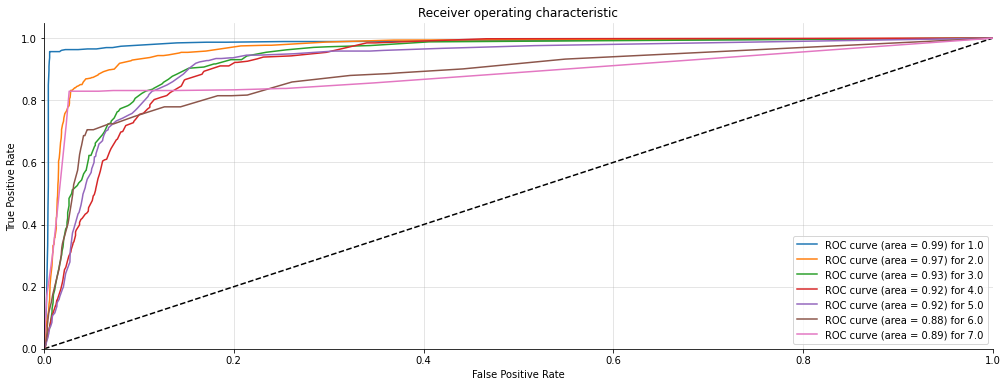

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       461
         2.0       0.83      0.86      0.84       488
         3.0       0.71      0.72      0.72       506
         4.0       0.65      0.64      0.64       516
         5.0       0.66      0.66      0.66       456
         6.0       0.73      0.71      0.72       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 419  58   4   1   3   0]
 [  1  19 366 118   0   2   0]
 [  1   0  40 329 140   6   0]
 [  2   2   9  30 302 111   0]
 [  2  15  17   9   6 336  86]
 [ 13  33  22  16   9   4 365]]
Accuracy Score : 0.7616071428571428
Precision Score : 0.7609470541118802
Recall Score : 0.7616071428571428
F1 Score : 0.7611920848297

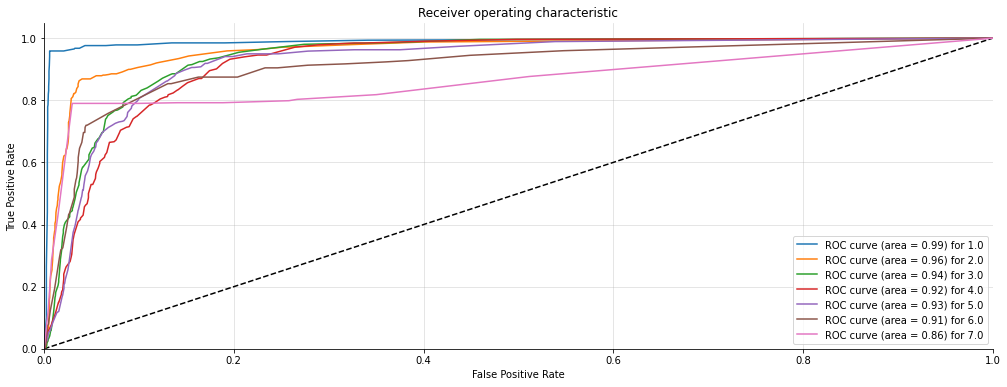

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.84      0.85      0.85       491
         3.0       0.82      0.77      0.79       487
         4.0       0.84      0.86      0.85       518
         5.0       0.91      0.92      0.92       487
         6.0       0.95      0.96      0.95       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [ 10 419  50   6   3   3   0]
 [  7  36 374  68   2   0   0]
 [  3  16  14 447  32   6   0]
 [  1   5  11   9 450  11   0]
 [  1   4   3   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.8991071428571429
Precision Score : 0.8986509505300635
Recall Score : 0.8991071428571429
F1 Score : 0.89870743376701

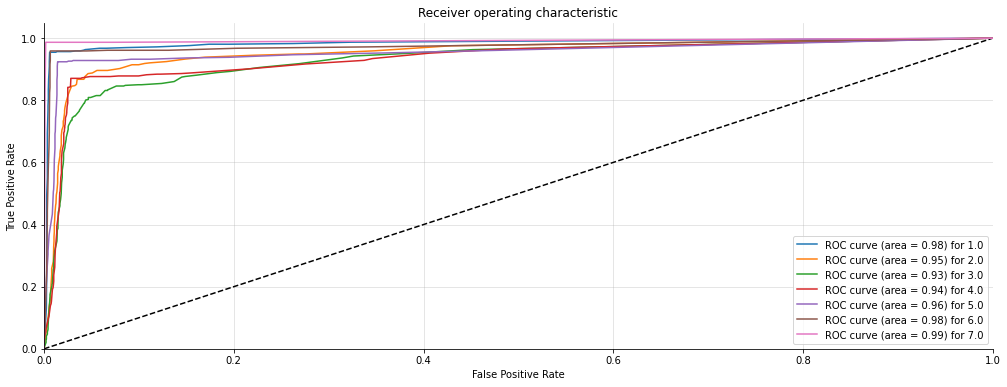

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       461
         2.0       0.85      0.84      0.84       495
         3.0       0.80      0.76      0.78       490
         4.0       0.81      0.83      0.82       519
         5.0       0.88      0.91      0.89       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.89      3360
   macro avg       0.89      0.89      0.89      3360
weighted avg       0.89      0.89      0.89      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  9 416  56   8   2   4   0]
 [ 10  29 373  74   3   1   0]
 [  3  18  21 429  47   1   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8889880952380952
Precision Score : 0.8884508427624297
Recall Score : 0.8889880952380952
F1 Score : 0.88

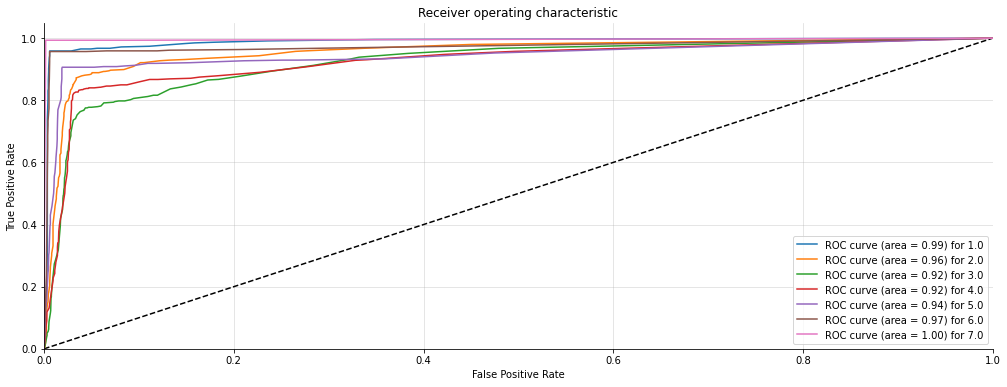

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99       460
         2.0       0.97      0.93      0.95       502
         3.0       0.93      0.93      0.93       474
         4.0       0.94      0.93      0.94       527
         5.0       0.95      0.98      0.97       486
         6.0       0.97      0.99      0.98       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.96      3360
   macro avg       0.96      0.96      0.96      3360
weighted avg       0.96      0.96      0.96      3360

Confusion Matrix: 
 [[455   5   0   0   0   0   0]
 [  7 467  18   6   4   0   0]
 [  0   9 440  17   6   2   0]
 [  0   1  17 490  10   9   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9625
Precision Score : 0.9625282983054626
Recall Score : 0.9625
F1 Score : 0.9624060687590903
Accuracy: 0.95

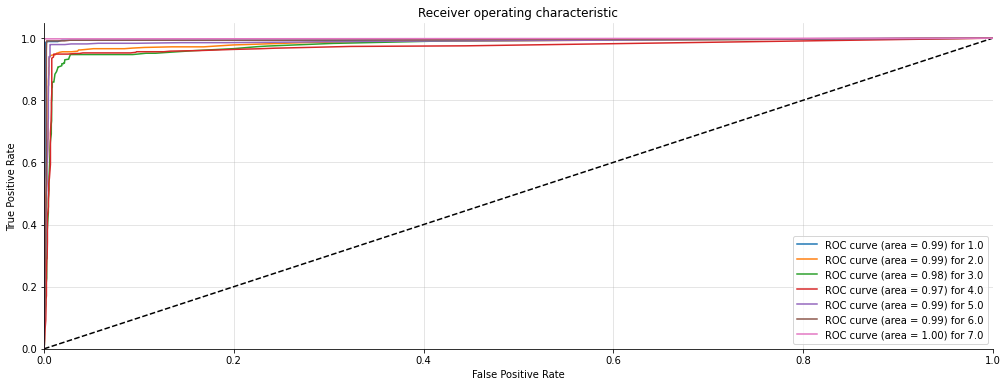

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99       459
         2.0       1.00      0.98      0.99       496
         3.0       0.99      0.99      0.99       478
         4.0       0.99      0.99      0.99       523
         5.0       0.99      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.99      3360
   macro avg       0.99      0.99      0.99      3360
weighted avg       0.99      0.99      0.99      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  7 484   0   2   3   0   0]
 [  0   1 475   2   0   0   0]
 [  0   0   3 520   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.9946428571428572
Precision Score : 0.994675095837348
Recall Score : 0.9946428571428572
F1 Score : 0.994631402704

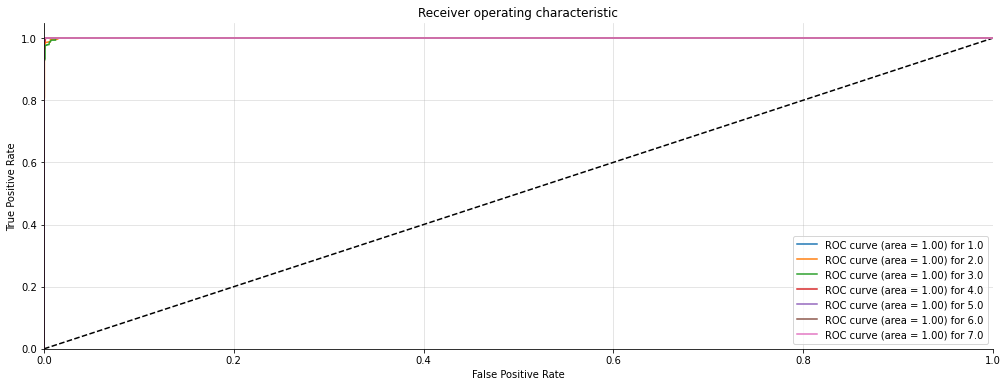

In [80]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
def BAG(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  BAG(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [81]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))

average Accuracy :0.85234375
average Precision :0.8518144974011381
average Recall :0.85234375
average F1 -score :0.8519465027668657
